## Pair Trading Study in Taiwan market

Pair trading has quite a well-known strategy that work on the concept of statistical arbitrage that takes advantage of mean reversion or convergence in the prices of two instruments. In order for the strategy to work, the spread between the two instruments should be fairly stationary. In addition, we will try to find mutiples pairs and fine tune this strategy by incorporating Martingale strategy when initiation,integrate stoploss and also explore the usage of kalman filter

#### Flow of this workbook

In [11]:
from IPython.display import Image

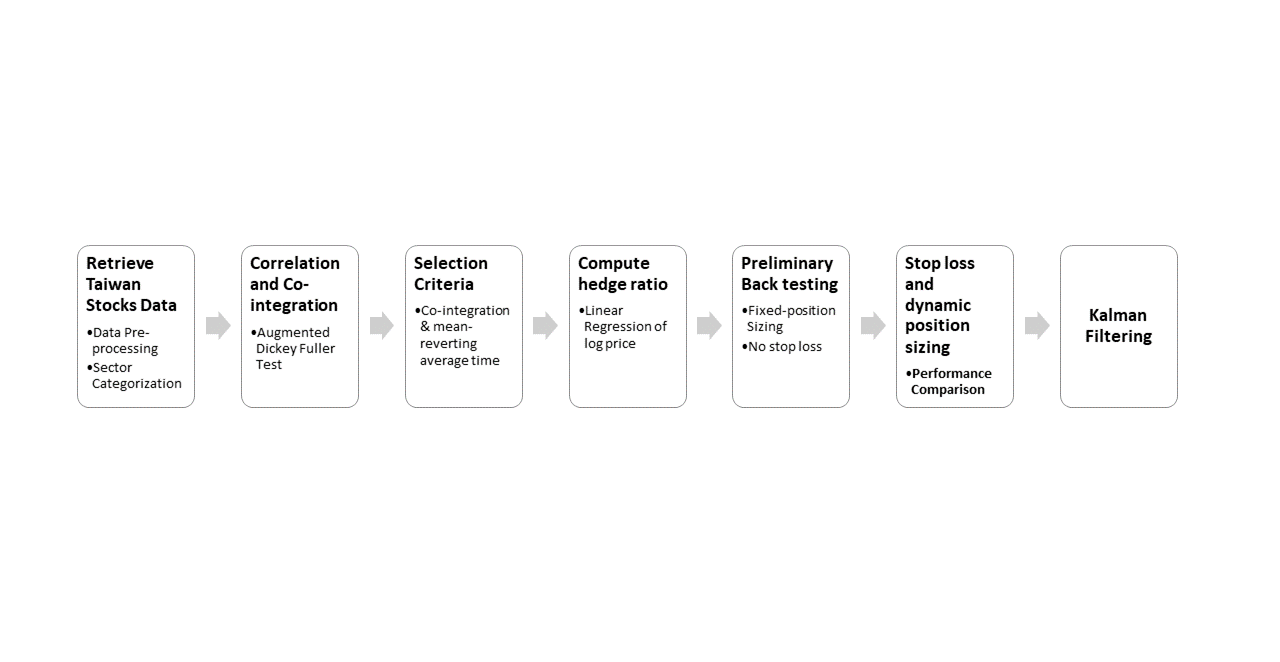

In [356]:
Image(filename="./Flowchart.PNG")

### 1. Retrieve Taiwan Stocks Data

#### Import Function and Libraries

The main source of data we will be using is from yahoo-finance which provides us with daily adjusted closing price. The main api is yfinance and we will merge the daily closing price as one dataframe.

In [154]:
import pandas as pd 
import numpy as np 
import yfinance as yf
from yahoofinancials import YahooFinancials
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from Data_Retrieval import DataRetrieval
from CC_test import CCstudy
import itertools
from pandas_datareader import data as pdr
from yahooquery import Ticker

In [155]:
from pykalman import KalmanFilter
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

In [156]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
from Spread import Spread

In [162]:
from time import time
from pathlib import Path
from tqdm import tqdm 

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [164]:
import warnings
warnings.filterwarnings('ignore')

#### Classification from Yahoo Query

Yahoo-query allows us to categorize the companies to their own sector and industry.

In [125]:
def classification(tickers):
    tickers = Ticker(tickers, asynchronous=True)
    
    datasi = tickers.get_modules("summaryProfile quoteType")
    dfsi = pd.DataFrame.from_dict(datasi).T
    dataframes = [pd.json_normalize([x for x in dfsi[module] if isinstance(x, dict)]) for
    module in ['summaryProfile', 'quoteType']]
    
    dfsi = pd.concat(dataframes, axis=1)
    
    dfsi = pd.DataFrame(dfsi.set_index('symbol'))
    dfsi=dfsi[['industry', 'sector']].reset_index()
    dfsi['symbol'].str.upper()
    return dfsi


#### Import TW exchange counters

In [241]:
counter_code = pd.read_csv('taiwan_stocks.csv')

In [242]:
tickers = list(counter_code.iloc[:,2])

In [244]:
tickers = list(counter_code.iloc[:,2].apply(lambda x: str(x)+".TW"))

In [245]:
tickers.append('0057.TW')

In [247]:
classlist = classification(tickers)

In [248]:
#tickers = ['2330.tw','0052.TW']
start_date = "2017-01-01"
end_date = "2022-12-31"

if tickers is not None:
    merged_df = DataRetrieval.retrieve_and_merge_data(tickers, start_date, end_date)
    display(merged_df)
else:
    print("Error: tickers is None")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

1303.TW    2002.TW    2303.TW     2330.TW    2881.TW    1301.TW  \
Date                                                                            
2017-01-03  47.744896  18.155310   7.756601  146.720306  28.845314  62.056217   
2017-01-04  48.080189  18.340946   7.722582  146.720306  28.676954  62.193962   
2017-01-05  49.220161  18.452330   7.756601  147.121170  28.845314  62.262840   
2017-01-06  49.220161  18.340946   7.892683  147.522049  28.957554  62.331711   
2017-01-09  49.488396  18.229563   7.892683  147.522049  29.013674  62.125088   
...               ...        ...        ...         ...        ...        ...   
2022-12-26  67.603493  29.110538  37.009628  439.635925  48.799320  81.555214   
2022-12-27  67.887535  28.825140  36.965462  440.117432  49.057060  81.836754   
2022-12-28  67.603493  29.110538  36.038013  434.339081  48.713398  81.555214   
2022-12-29  66.656662  28.492178  35.993847  429.523773  48.112003  80.804413   
2022-12-30  67.224754  28.349478  35.949688  431.931427  48.369743  81.461357   

              2324.TW    2409.TW    2880.TW    2882.TW  ...    1905.TW  \
Date                                                    ...              
2017-01-03  11.817386   9.065211   9.712663  33.428658  ...   7.900724   
2017-01-04  11.817386   9.027439   9.682777  33.359016  ...   7.866373   
2017-01-05  11.912430   9.254069   9.772433  33.707233  ...   8.433164   
2017-01-06  11.880751   9.480700   9.802317  33.950985  ...   8.544804   
2017-01-09  11.817386   9.707330   9.832202  34.125095  ...   8.355873   
...               ...        ...        ...        ...  ...        ...   
2022-12-26  21.237064  14.137062  20.804043  38.802715  ...  16.118553   
2022-12-27  21.237064  14.137062  20.896095  38.944679  ...  16.217440   
2022-12-28  21.190897  13.817837  20.665962  38.471474  ...  16.019667   
2022-12-29  21.283230  13.772235  20.527882  37.950947  ...  15.920780   
2022-12-30  21.283230  13.681026  20.665962  37.856308  ...  15.970222   

              1513.TW    3005.TW    8112.TW    1503.TW    6139.TW    5876.TW  \
Date                                                                           
2017-01-03  14.171649  24.109896  12.488032  32.763050  25.612844  18.710472   
2017-01-04  14.171649  24.263853  12.657773  32.763050  26.067717  18.842136   
2017-01-05  14.756045  24.633352  12.827514  32.803547  25.717815  18.814419   
2017-01-06  15.011719  24.356226  12.851764  32.803547  25.647833  18.897573   
2017-01-09  14.938670  25.341564  12.997255  32.398560  25.052999  18.918365   
...               ...        ...        ...        ...        ...        ...   
2022-12-26  63.613621  39.275623  30.166748  58.065128  35.414677  40.638802   
2022-12-27  64.474556  39.140503  30.250895  59.335915  35.368683  40.823315   
2022-12-28  64.091919  38.870258  30.124672  58.749397  35.552658  40.731060   
2022-12-29  64.091919  39.275623  29.998451  58.162876  34.264851  40.500420   
2022-12-30  64.283234  39.771076  30.124672  59.140408  34.632797  40.638802   

              6505.TW  6526.TW    0057.TW  
Date                                       
2017-01-03  83.657341      NaN  41.990002  
2017-01-04  83.657341      NaN  42.220001  
2017-01-05  84.803329      NaN  42.610001  
2017-01-06  83.275337      NaN  42.639999  
2017-01-09  83.275337      NaN  42.580002  
...               ...      ...        ...  
2022-12-26  76.884575      NaN  79.099998  
2022-12-27  77.554787      NaN  79.500000  
2022-12-28  77.076065      NaN  78.099998  
2022-12-29  76.310081      NaN  77.650002  
2022-12-30  76.884575      NaN  78.599998  

[1465 rows x 194 columns]

In [251]:
merged_df = merged_df.dropna(axis=1, how='any')

In [252]:
merged_df

1303.TW    2002.TW    2303.TW     2330.TW    2881.TW    1301.TW  \
Date                                                                            
2017-01-03  47.744896  18.155310   7.756601  146.720306  28.845314  62.056217   
2017-01-04  48.080189  18.340946   7.722582  146.720306  28.676954  62.193962   
2017-01-05  49.220161  18.452330   7.756601  147.121170  28.845314  62.262840   
2017-01-06  49.220161  18.340946   7.892683  147.522049  28.957554  62.331711   
2017-01-09  49.488396  18.229563   7.892683  147.522049  29.013674  62.125088   
...               ...        ...        ...         ...        ...        ...   
2022-12-26  67.603493  29.110538  37.009628  439.635925  48.799320  81.555214   
2022-12-27  67.887535  28.825140  36.965462  440.117432  49.057060  81.836754   
2022-12-28  67.603493  29.110538  36.038013  434.339081  48.713398  81.555214   
2022-12-29  66.656662  28.492178  35.993847  429.523773  48.112003  80.804413   
2022-12-30  67.224754  28.349478  35.949688  431.931427  48.369743  81.461357   

              2324.TW    2409.TW    2880.TW    2882.TW  ...     1795.TW  \
Date                                                    ...               
2017-01-03  11.817386   9.065211   9.712663  33.428658  ...   56.543301   
2017-01-04  11.817386   9.027439   9.682777  33.359016  ...   57.592171   
2017-01-05  11.912430   9.254069   9.772433  33.707233  ...   58.164272   
2017-01-06  11.880751   9.480700   9.802317  33.950985  ...   57.306110   
2017-01-09  11.817386   9.707330   9.832202  34.125095  ...   55.780495   
...               ...        ...        ...        ...  ...         ...   
2022-12-26  21.237064  14.137062  20.804043  38.802715  ...  233.449463   
2022-12-27  21.237064  14.137062  20.896095  38.944679  ...  230.537415   
2022-12-28  21.190897  13.817837  20.665962  38.471474  ...  231.508087   
2022-12-29  21.283230  13.772235  20.527882  37.950947  ...  242.670959   
2022-12-30  21.283230  13.681026  20.665962  37.856308  ...  238.788223   

              1905.TW    1513.TW    3005.TW    8112.TW    1503.TW    6139.TW  \
Date                                                                           
2017-01-03   7.900724  14.171649  24.109896  12.488032  32.763050  25.612844   
2017-01-04   7.866373  14.171649  24.263853  12.657773  32.763050  26.067717   
2017-01-05   8.433164  14.756045  24.633352  12.827514  32.803547  25.717815   
2017-01-06   8.544804  15.011719  24.356226  12.851764  32.803547  25.647833   
2017-01-09   8.355873  14.938670  25.341564  12.997255  32.398560  25.052999   
...               ...        ...        ...        ...        ...        ...   
2022-12-26  16.118553  63.613621  39.275623  30.166748  58.065128  35.414677   
2022-12-27  16.217440  64.474556  39.140503  30.250895  59.335915  35.368683   
2022-12-28  16.019667  64.091919  38.870258  30.124672  58.749397  35.552658   
2022-12-29  15.920780  64.091919  39.275623  29.998451  58.162876  34.264851   
2022-12-30  15.970222  64.283234  39.771076  30.124672  59.140408  34.632797   

              5876.TW    6505.TW    0057.TW  
Date                                         
2017-01-03  18.710472  83.657341  41.990002  
2017-01-04  18.842136  83.657341  42.220001  
2017-01-05  18.814419  84.803329  42.610001  
2017-01-06  18.897573  83.275337  42.639999  
2017-01-09  18.918365  83.275337  42.580002  
...               ...        ...        ...  
2022-12-26  40.638802  76.884575  79.099998  
2022-12-27  40.823315  77.554787  79.500000  
2022-12-28  40.731060  77.076065  78.099998  
2022-12-29  40.500420  76.310081  77.650002  
2022-12-30  40.638802  76.884575  78.599998  

[1465 rows x 187 columns]

### Correlation and Cointegration Study 


Cointegration Test Results:


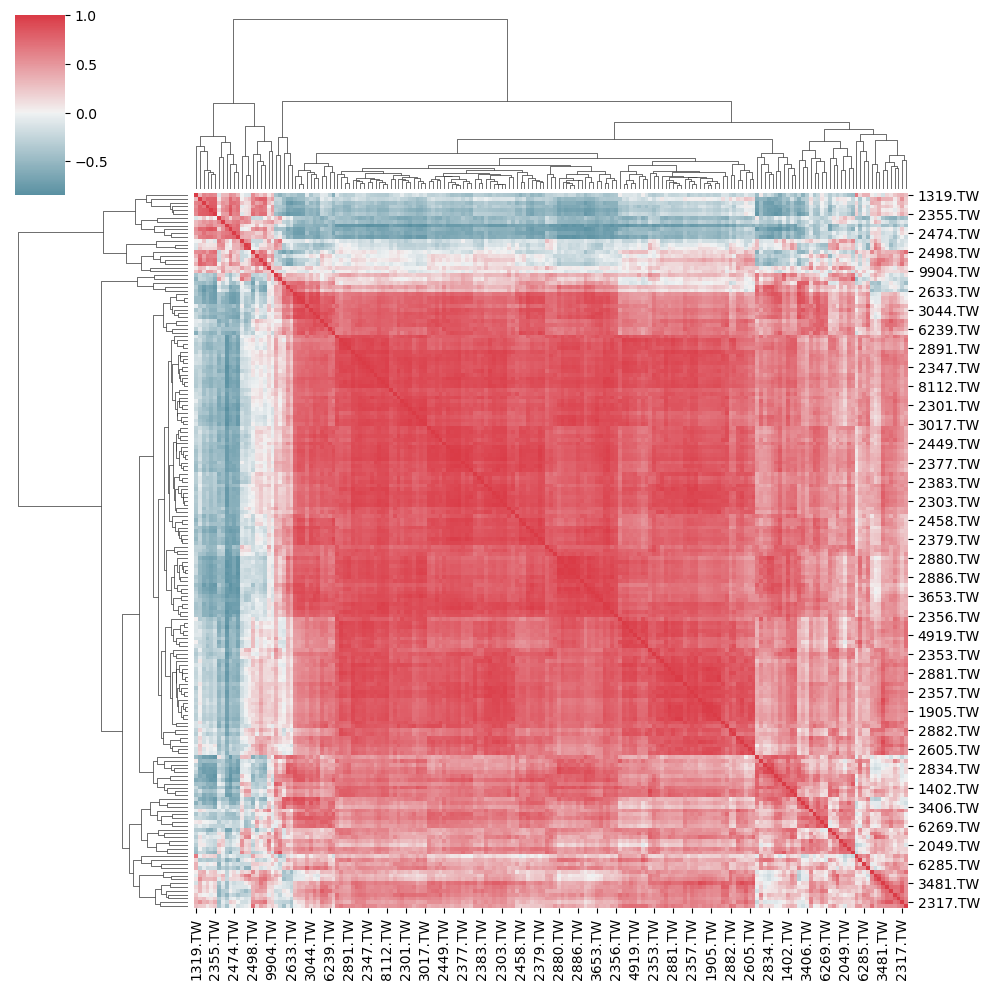

In [258]:
cc_study = CCstudy(merged_df)
table = cc_study.main()

In [260]:
table.sort_values(by=['Cointegration result','correlation'],ascending =[True,False])

ticker1  ticker2  Cointegration result  correlation
892   2881.TW  2606.TW              0.000009     0.931947
5031  2337.TW  2393.TW              0.000009     0.681998
4830  2317.TW  2337.TW              0.000011     0.618397
6750  3231.TW  3406.TW              0.000015     0.708276
5030  2337.TW  2392.TW              0.000031     0.720365
...       ...      ...                   ...          ...
9095  2201.TW  9938.TW              0.984402     0.205962
2723  1605.TW  2049.TW              0.984614     0.033374
2695  1605.TW  1101.TW              0.985012     0.618966
2685  1605.TW  2323.TW              0.987923     0.250570
2753  1605.TW  2492.TW              0.994189    -0.016772

[17391 rows x 4 columns]

In [316]:
table1 =table[(table['Cointegration result'] < 0.005) & (table['correlation'] > 0.7)].sort_values(by=['correlation','Cointegration result'],ascending =[False,True])

In [318]:
def categorize(classlist,column,counter):
    if column == 'industry':
        a=pd.DataFrame(dict(classlist.iloc[:,0:2]))
        return table[counter].map(a.set_index('symbol')[column])
    elif column == 'sector':
        b= pd.DataFrame(dict(classlist.iloc[:,[0,2]]))
        return table[counter].map(b.set_index('symbol')[column])
    else:
        return 'Error'

In [319]:
table1['ticker1_industry'] = categorize(classlist,'sector','ticker1')
table1['ticker2_industry'] = categorize(classlist,'sector','ticker2')


In [321]:
table1

ticker1  ticker2  Cointegration result  correlation  \
1203   2324.TW  3702.TW              0.000365     0.969606   
6977   1210.TW  2377.TW              0.002491     0.933416   
7633   1440.TW  2606.TW              0.000623     0.932146   
892    2881.TW  2606.TW              0.000009     0.931947   
10093  2344.TW  6116.TW              0.003936     0.919287   
12633  2542.TW  1503.TW              0.002589     0.916940   
6609   2915.TW  2883.TW              0.004222     0.913110   
10807  2385.TW  3706.TW              0.003848     0.912161   
5373   2382.TW  3380.TW              0.002284     0.911741   
10778  2385.TW  3044.TW              0.004309     0.906916   
5273   2357.TW  2606.TW              0.003532     0.906395   
15023  6271.TW  8150.TW              0.000138     0.903369   
14977  6271.TW  6282.TW              0.003052     0.901437   
11326  2449.TW  6271.TW              0.002534     0.900890   
17034  2606.TW  8112.TW              0.004643     0.892223   
6723   3231.TW  3380.TW              0.000887     0.891976   
2774   1605.TW  3443.TW              0.003996     0.890496   
16328  1476.TW  2606.TW              0.003756     0.886581   
10406  2376.TW  3443.TW              0.003247     0.885827   
14089  3443.TW  9945.TW              0.004573     0.884633   
324    2002.TW  1476.TW              0.004318     0.882618   
7564   1440.TW  2605.TW              0.004857     0.878109   
5386   2382.TW  6271.TW              0.004912     0.866749   
7602   1440.TW  2328.TW              0.001505     0.866617   
3167   2352.TW  2606.TW              0.002519     0.862055   
9487   2312.TW  3706.TW              0.002271     0.852485   
5509   2412.TW  2515.TW              0.004240     0.848796   
9914   2340.TW  2618.TW              0.004289     0.848532   
15256  8039.TW  6269.TW              0.002199     0.843941   
13061  2913.TW  2356.TW              0.003669     0.841588   
9438   2312.TW  3702.TW              0.004386     0.840523   
9417   2312.TW  2542.TW              0.000847     0.839822   
9509   2312.TW  3005.TW              0.001021     0.830619   
5204   2357.TW  2605.TW              0.001969     0.808754   
6632   2915.TW  2606.TW              0.004759     0.803656   
14910  6239.TW  8039.TW              0.003010     0.802597   
12772  2605.TW  2328.TW              0.000479     0.799163   
13932  3376.TW  3406.TW              0.000066     0.794712   
3372   2408.TW  2337.TW              0.000248     0.792795   
9511   2312.TW  1503.TW              0.003003     0.791641   
15851  3406.TW  6269.TW              0.000816     0.783210   
15255  8039.TW  3406.TW              0.000510     0.781352   
9400   2312.TW  2385.TW              0.003257     0.780568   
12376  2515.TW  8163.TW              0.003669     0.778039   
5074   2337.TW  6239.TW              0.000068     0.740077   
15739  3044.TW  3406.TW              0.000143     0.736528   
5079   2337.TW  8039.TW              0.000238     0.733665   
5122   2337.TW  2441.TW              0.000068     0.726596   
5019   2337.TW  2313.TW              0.002888     0.721078   
5030   2337.TW  2392.TW              0.000031     0.720365   
5103   2337.TW  2360.TW              0.001716     0.710942   
5112   2337.TW  3711.TW              0.002595     0.709789   
6750   3231.TW  3406.TW              0.000015     0.708276   
5034   2337.TW  2449.TW              0.000038     0.703845   
14920  6239.TW  3406.TW              0.000048     0.703773   
12104  2489.TW  1909.TW              0.001301     0.702333   
15857  3406.TW  4958.TW              0.000249     0.700218   
5107   2337.TW  6116.TW              0.000174     0.700176   

             ticker1_industry    ticker2_industry  
1203               Technology          Technology  
6977       Consumer Defensive          Technology  
7633        Consumer Cyclical         Industrials  
892        Financial Services         Industrials  
10093              Technology          Technology  
12633             Real Estate       

### Selection of pair trading

In order to remove any industry specific systematic risk, the first criteria should be that the pair of stocks should belong to the same industry. Next, we shall run the time series spread graph.

In [332]:
Pair = []
for index, row in table1.iterrows():
    if row['ticker1_industry'] == row['ticker2_industry']:
        Pair.append([row['ticker1'],row['ticker2']])

In [334]:
Pair

[['2324.TW', '3702.TW'],
 ['2344.TW', '6116.TW'],
 ['2385.TW', '3706.TW'],
 ['2382.TW', '3380.TW'],
 ['2385.TW', '3044.TW'],
 ['6271.TW', '8150.TW'],
 ['2449.TW', '6271.TW'],
 ['3231.TW', '3380.TW'],
 ['2376.TW', '3443.TW'],
 ['2382.TW', '6271.TW'],
 ['2312.TW', '3706.TW'],
 ['8039.TW', '6269.TW'],
 ['2312.TW', '3702.TW'],
 ['2312.TW', '3005.TW'],
 ['6239.TW', '8039.TW'],
 ['2408.TW', '2337.TW'],
 ['3406.TW', '6269.TW'],
 ['8039.TW', '3406.TW'],
 ['2312.TW', '2385.TW'],
 ['2337.TW', '6239.TW'],
 ['3044.TW', '3406.TW'],
 ['2337.TW', '8039.TW'],
 ['2337.TW', '2441.TW'],
 ['2337.TW', '2313.TW'],
 ['2337.TW', '2392.TW'],
 ['2337.TW', '2360.TW'],
 ['2337.TW', '3711.TW'],
 ['3231.TW', '3406.TW'],
 ['2337.TW', '2449.TW'],
 ['6239.TW', '3406.TW'],
 ['3406.TW', '4958.TW'],
 ['2337.TW', '6116.TW']]

Statistics for the spread between 2324.TW and 3702.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.232665 -4.530681        -4.123517        -4.937844   

   Revert Time  
0    82.296296  


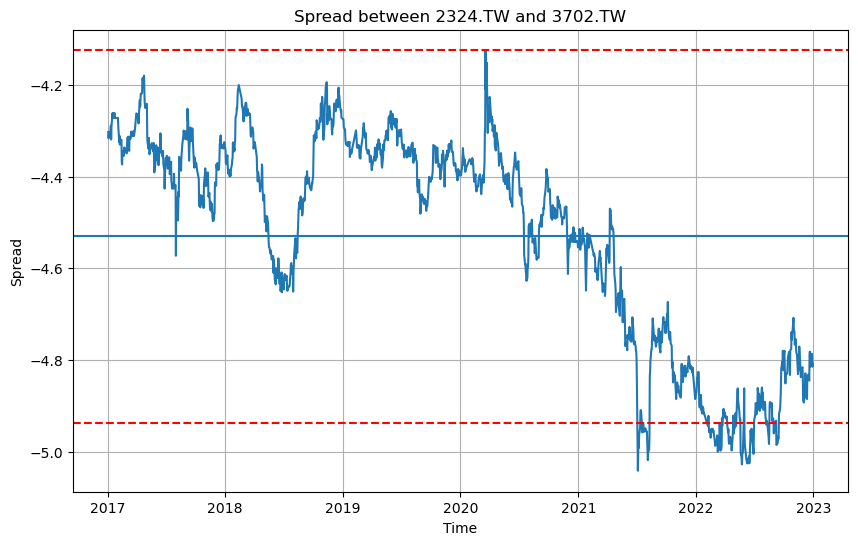

Statistics for the spread between 2344.TW and 6116.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.232665 -4.530681        -4.123517        -4.937844   
1  2344.TW  6116.TW    0.176941  1.655437         1.965085         1.345790   

   Revert Time  
0    82.296296  
1    46.854167  


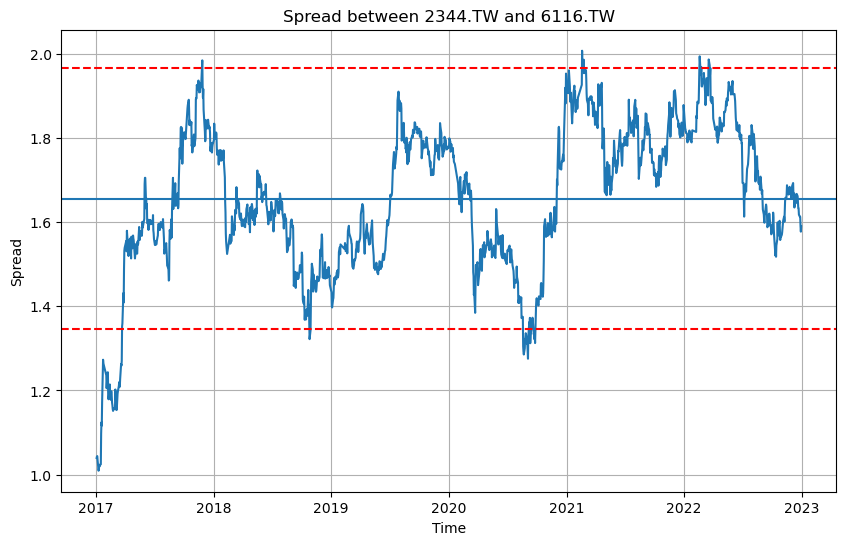

Statistics for the spread between 2385.TW and 3706.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.232665 -4.530681        -4.123517        -4.937844   
1  2344.TW  6116.TW    0.176941  1.655437         1.965085         1.345790   
2  2385.TW  3706.TW    0.123593  2.962438         3.178726         2.746149   

   Revert Time  
0    82.296296  
1    46.854167  
2    39.274510  


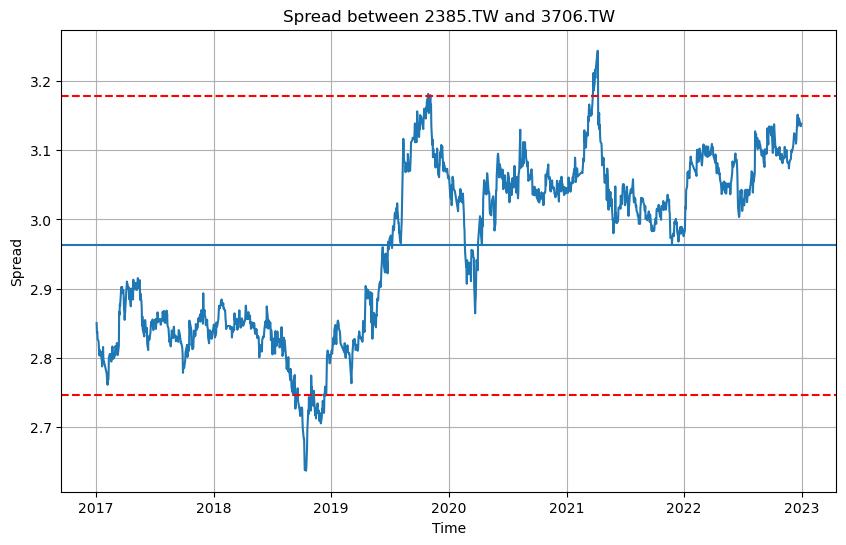

Statistics for the spread between 2382.TW and 3380.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.232665 -4.530681        -4.123517        -4.937844   
1  2344.TW  6116.TW    0.176941  1.655437         1.965085         1.345790   
2  2385.TW  3706.TW    0.123593  2.962438         3.178726         2.746149   
3  2382.TW  3380.TW    0.179069  2.853083         3.166453         2.539713   

   Revert Time  
0    82.296296  
1    46.854167  
2    39.274510  
3    58.027778  


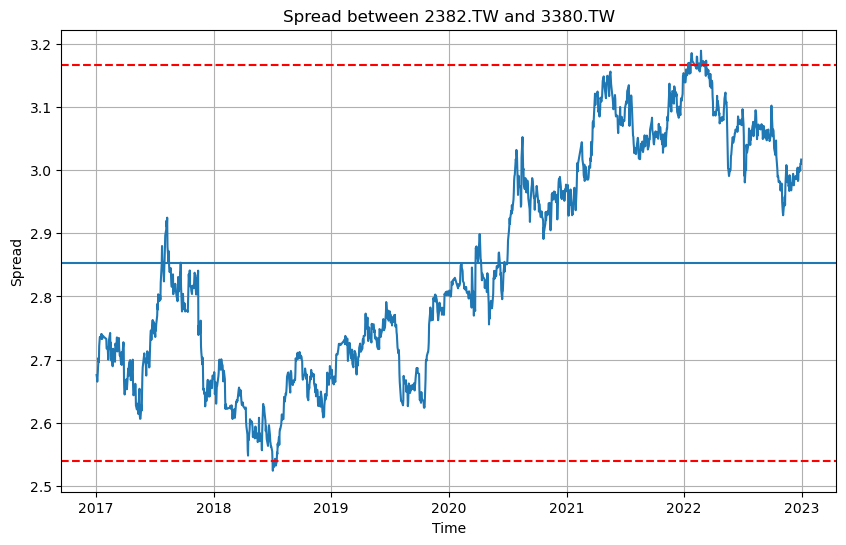

Statistics for the spread between 2385.TW and 3044.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.232665 -4.530681        -4.123517        -4.937844   
1  2344.TW  6116.TW    0.176941  1.655437         1.965085         1.345790   
2  2385.TW  3706.TW    0.123593  2.962438         3.178726         2.746149   
3  2382.TW  3380.TW    0.179069  2.853083         3.166453         2.539713   
4  2385.TW  3044.TW    0.194506 -2.594393        -2.254008        -2.934778   

   Revert Time  
0    82.296296  
1    46.854167  
2    39.274510  
3    58.027778  
4    63.363636  


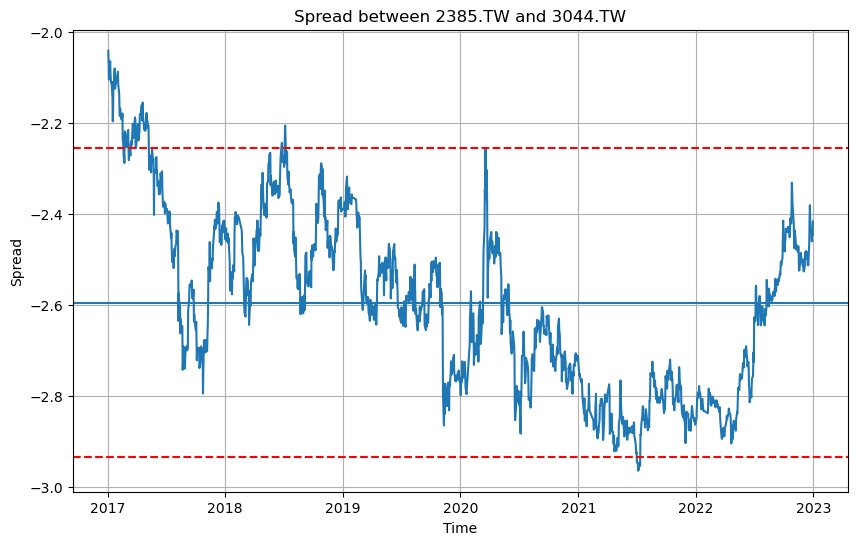

Statistics for the spread between 6271.TW and 8150.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.232665 -4.530681        -4.123517        -4.937844   
1  2344.TW  6116.TW    0.176941  1.655437         1.965085         1.345790   
2  2385.TW  3706.TW    0.123593  2.962438         3.178726         2.746149   
3  2382.TW  3380.TW    0.179069  2.853083         3.166453         2.539713   
4  2385.TW  3044.TW    0.194506 -2.594393        -2.254008        -2.934778   
5  6271.TW  8150.TW    0.219125  4.221005         4.604474         3.837537   

   Revert Time  
0    82.296296  
1    46.854167  
2    39.274510  
3    58.027778  
4    63.363636  
5    49.688889  


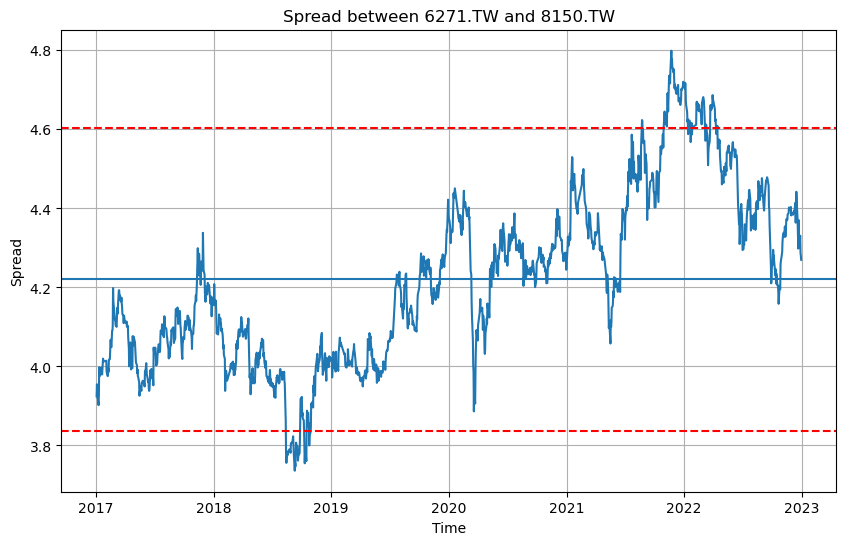

Statistics for the spread between 2449.TW and 6271.TW: 
  Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1  2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2  2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3  2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4  2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5  6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6  2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   

   Revert Time  
0    82.296296  
1    46.854167  
2    39.274510  
3    58.027778  
4    63.363636  
5    49.688889  
6    64.558824  


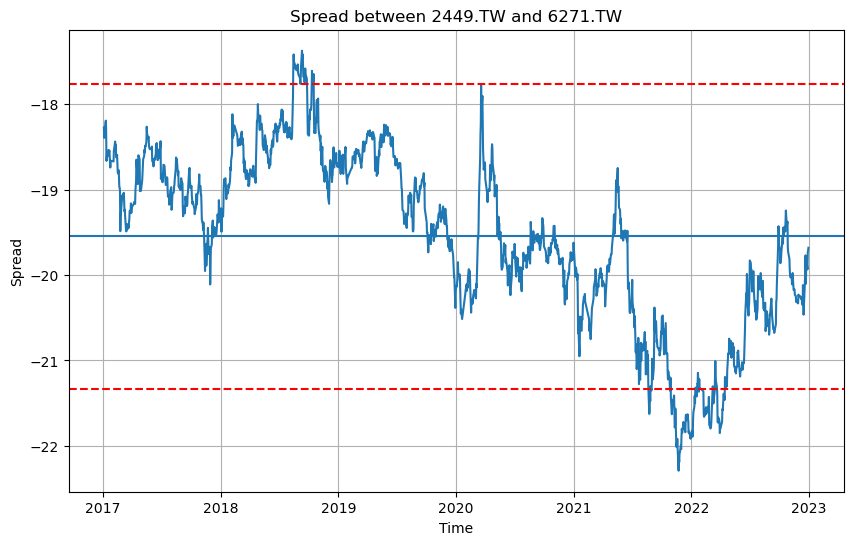

Statistics for the spread between 3231.TW and 3380.TW: 
  Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1  2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2  2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3  2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4  2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5  6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6  2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7  3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   

   Revert Time  
0    82.296296  
1    46.854167  
2    39.274510  
3    58.027778  
4    63.363636  
5    49.688889  
6    64.558824  
7    41.553571  


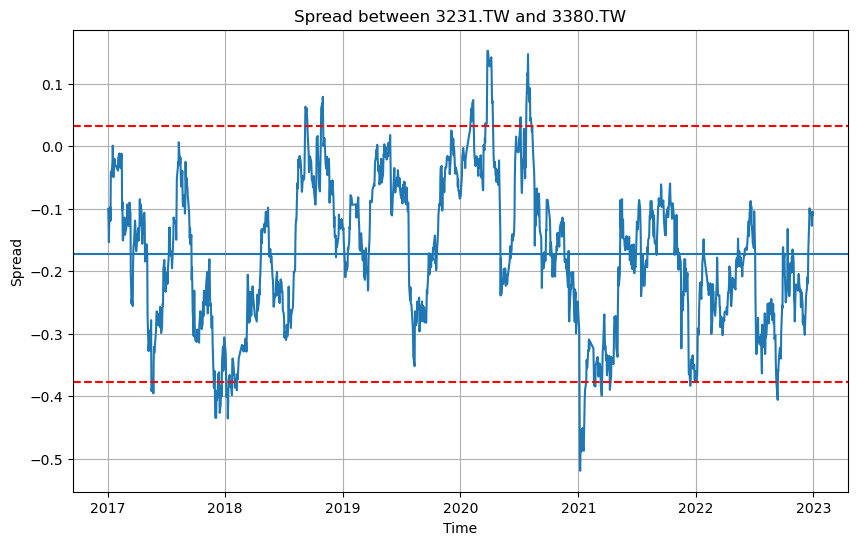

Statistics for the spread between 2376.TW and 3443.TW: 
  Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1  2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2  2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3  2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4  2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5  6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6  2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7  3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8  2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   

   Revert Time  
0    82.296296  
1    46.854167  
2    39.274510  
3    58.027778  
4    63.363636  
5    49.688889  
6    64.558824  
7    41

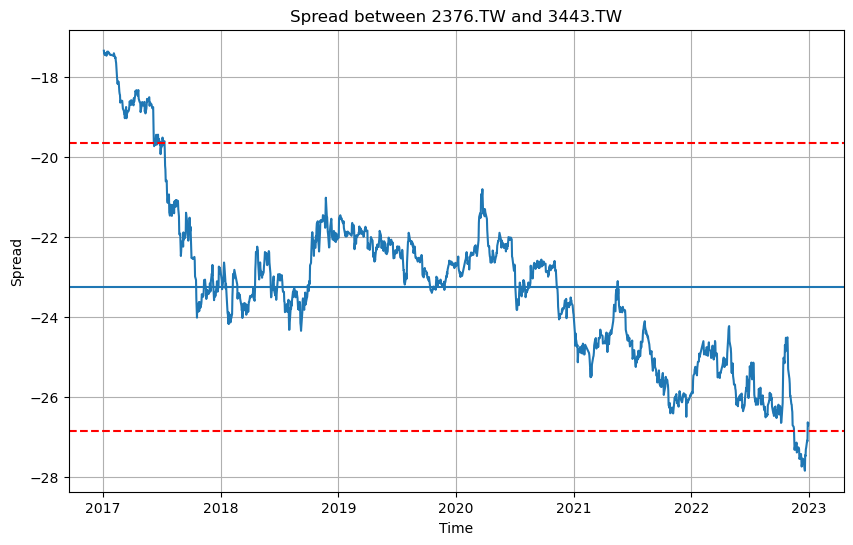

Statistics for the spread between 2382.TW and 6271.TW: 
  Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1  2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2  2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3  2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4  2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5  6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6  2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7  3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8  2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9  2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   

   Revert Time  
0    82.296296  
1    46.854167  
2    39.2745

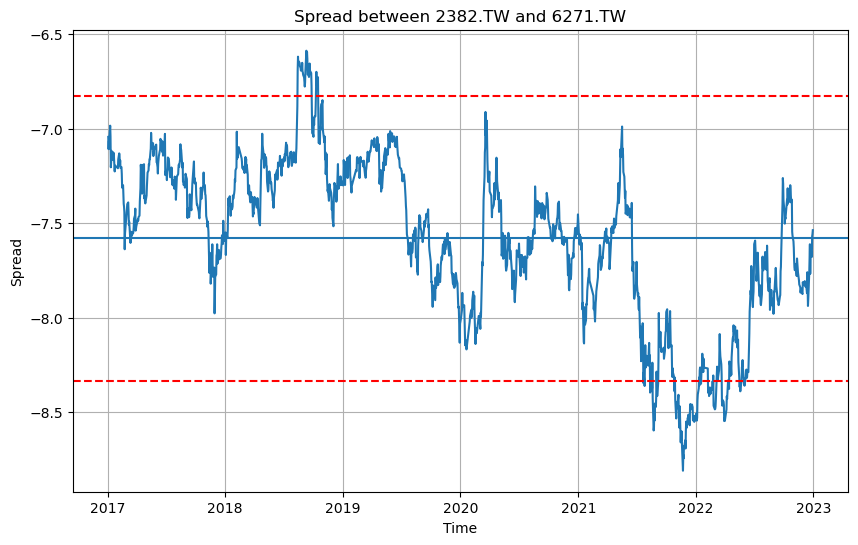

Statistics for the spread between 2312.TW and 3706.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

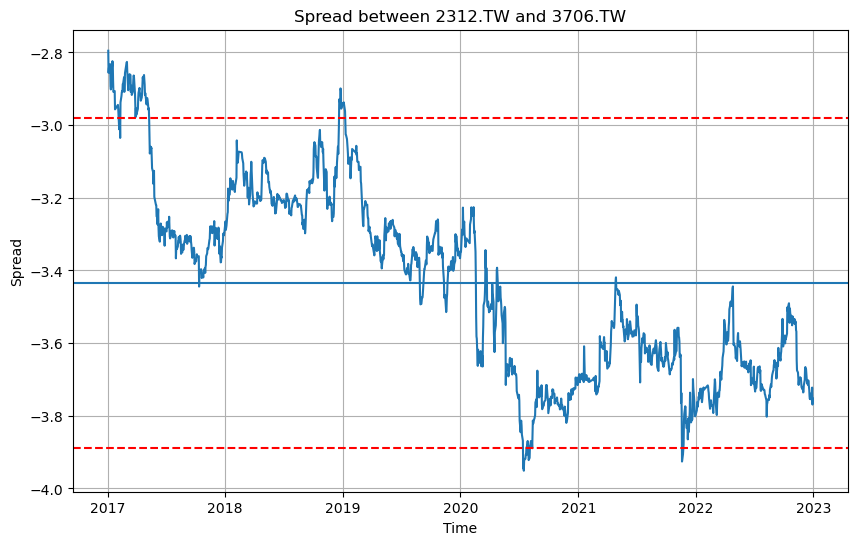

Statistics for the spread between 8039.TW and 6269.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

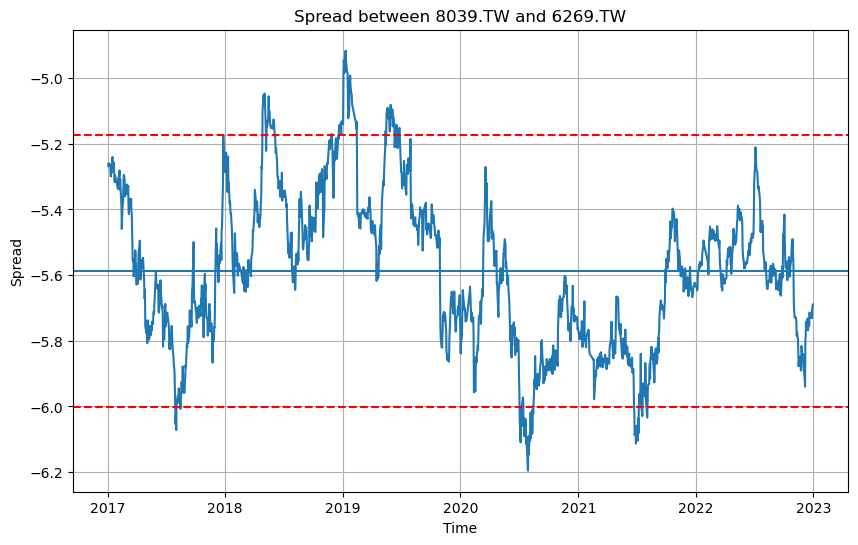

Statistics for the spread between 2312.TW and 3702.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

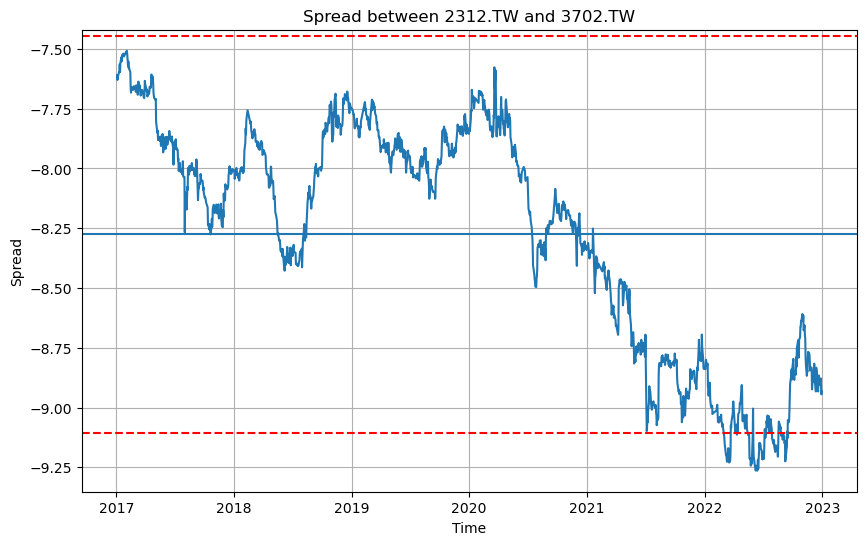

Statistics for the spread between 2312.TW and 3005.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

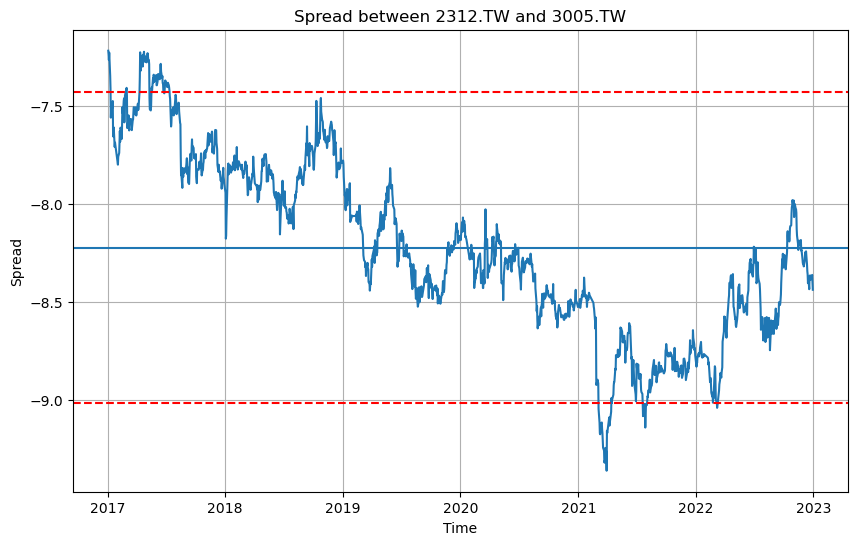

Statistics for the spread between 6239.TW and 8039.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

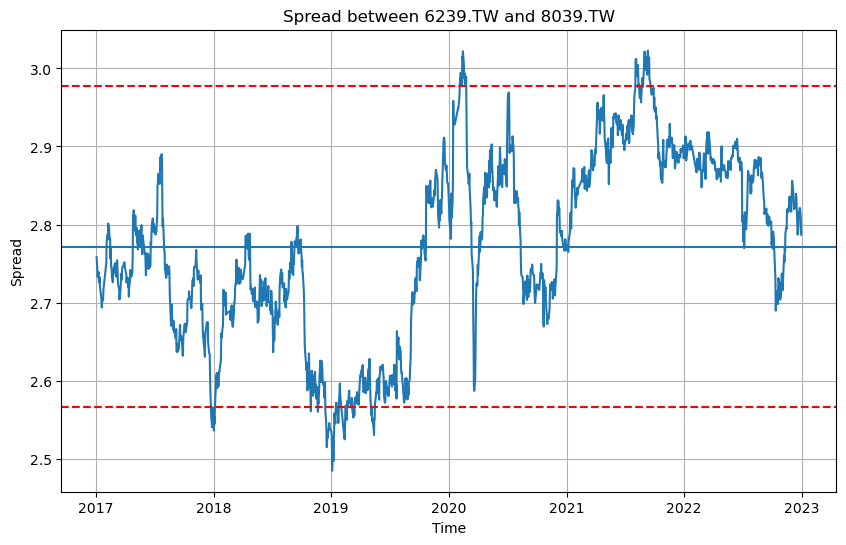

Statistics for the spread between 2408.TW and 2337.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

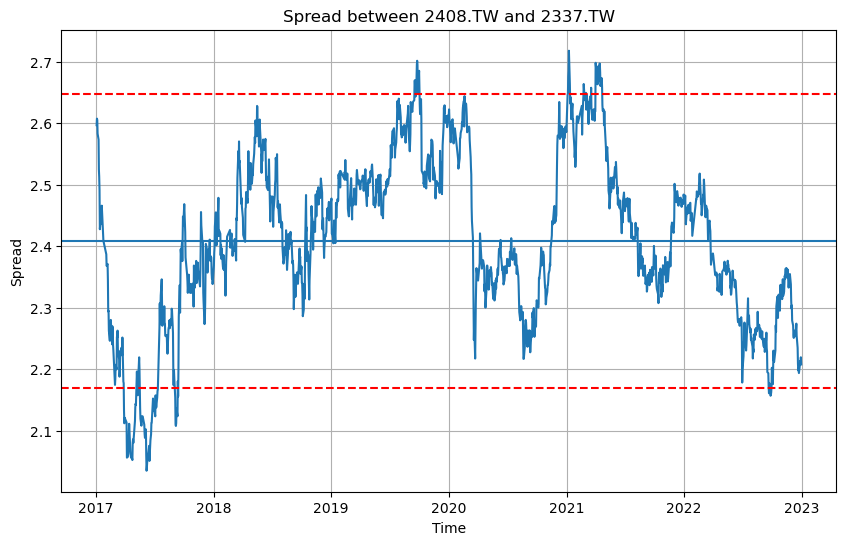

Statistics for the spread between 3406.TW and 6269.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

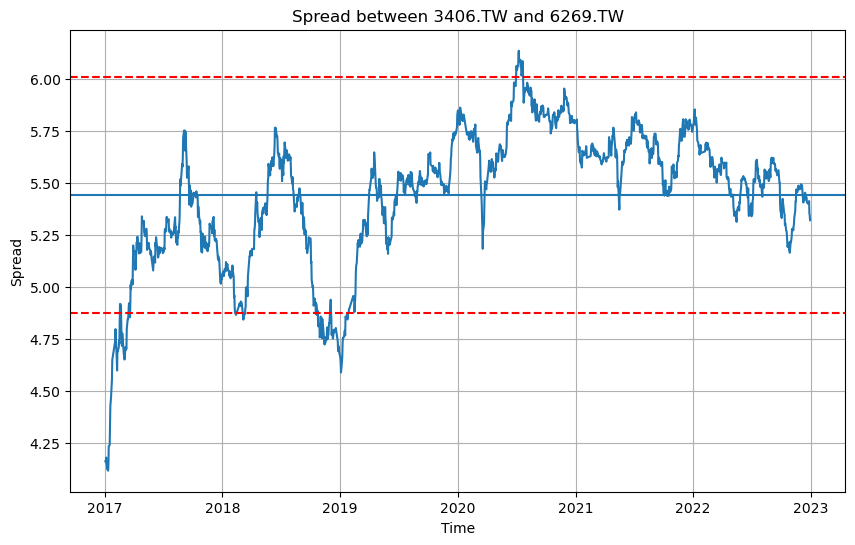

Statistics for the spread between 8039.TW and 3406.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

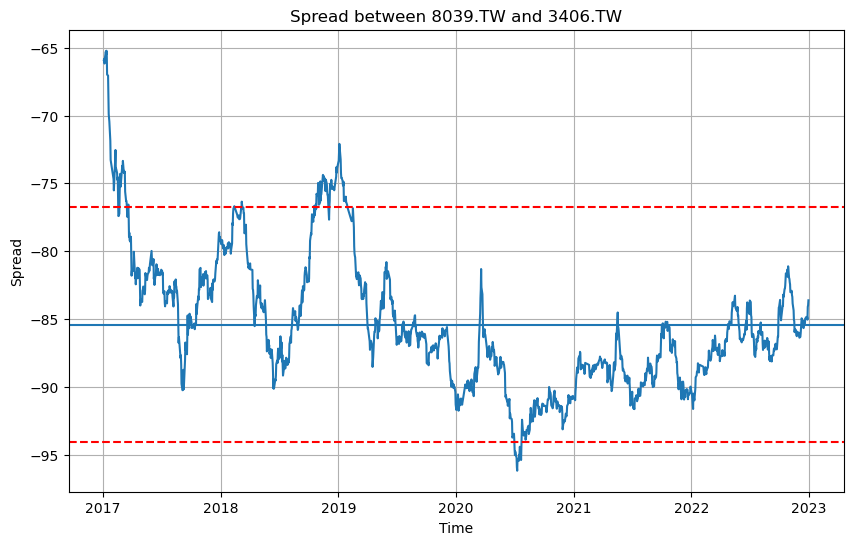

Statistics for the spread between 2312.TW and 2385.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

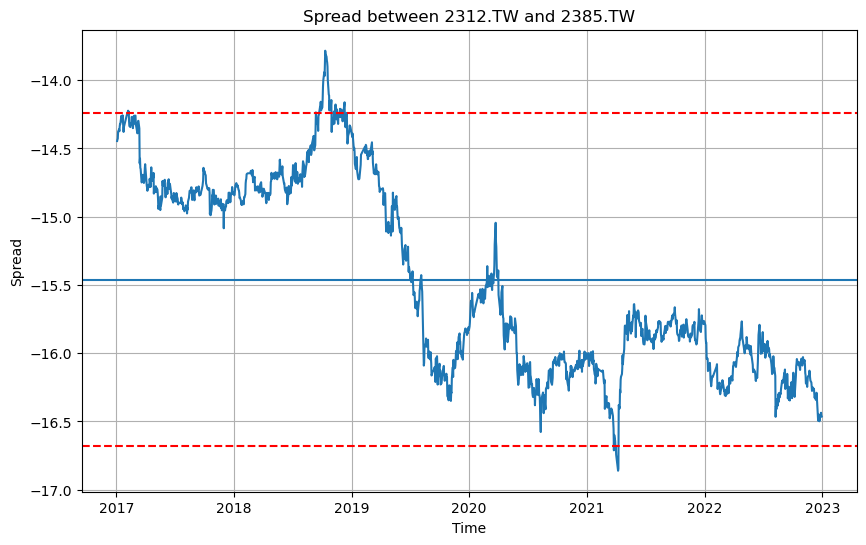

Statistics for the spread between 2337.TW and 6239.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

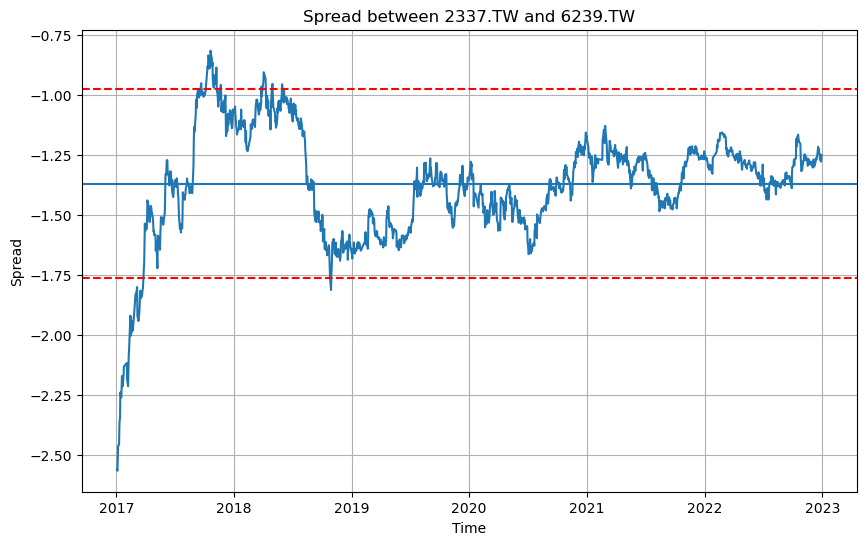

Statistics for the spread between 3044.TW and 3406.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

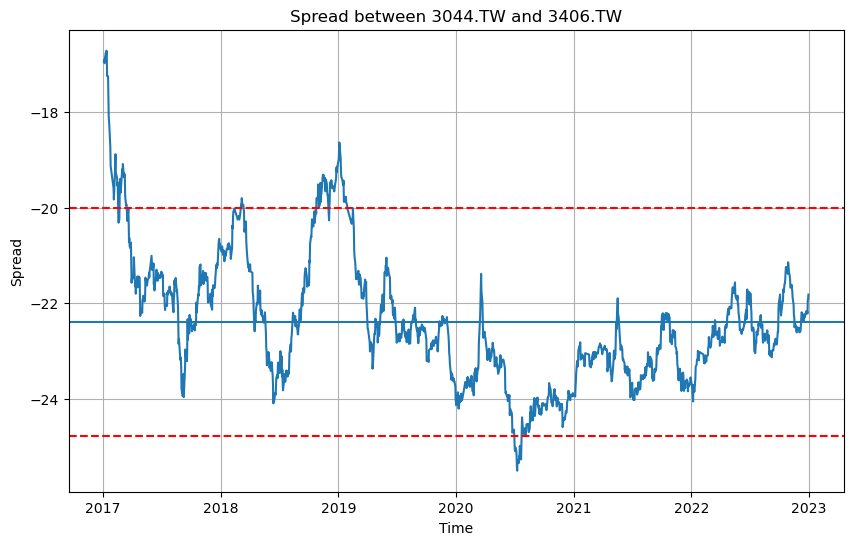

Statistics for the spread between 2337.TW and 8039.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

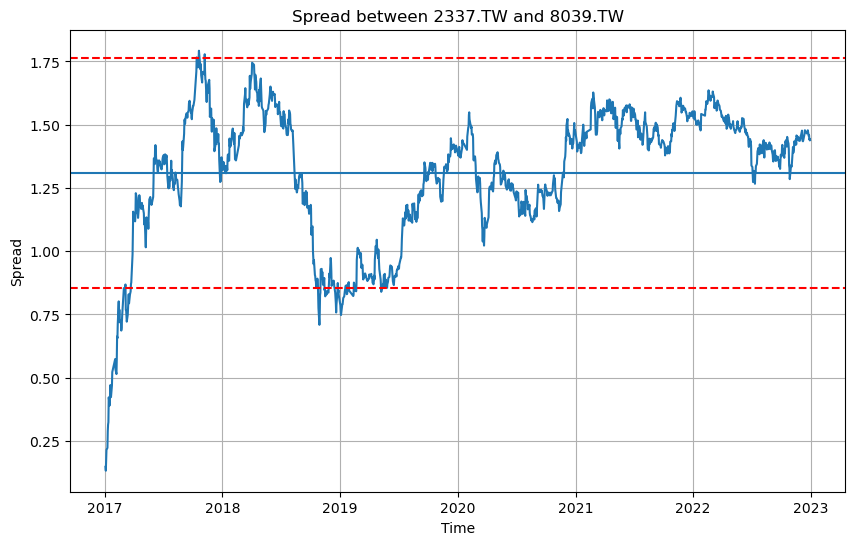

Statistics for the spread between 2337.TW and 2441.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

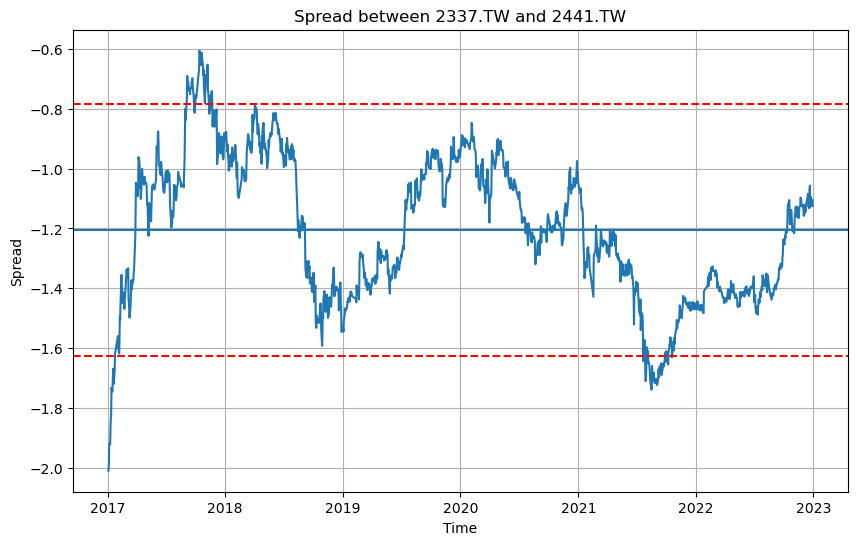

Statistics for the spread between 2337.TW and 2313.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

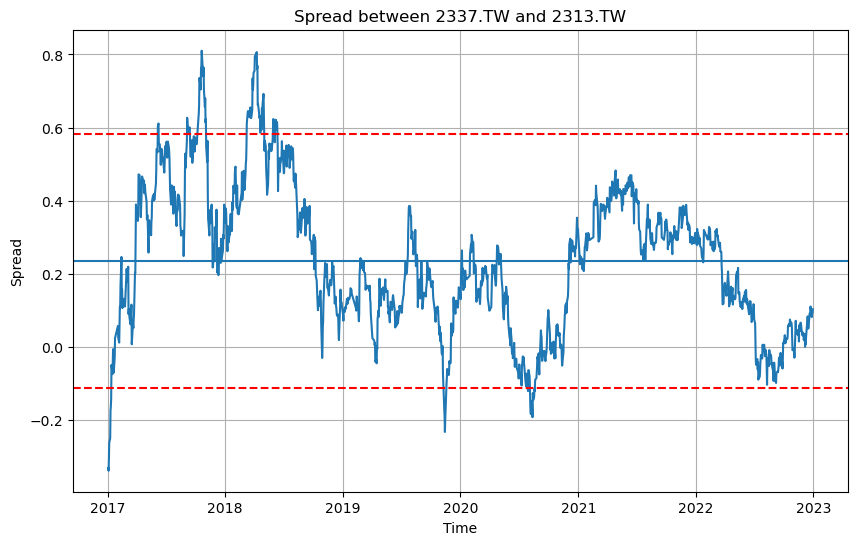

Statistics for the spread between 2337.TW and 2392.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

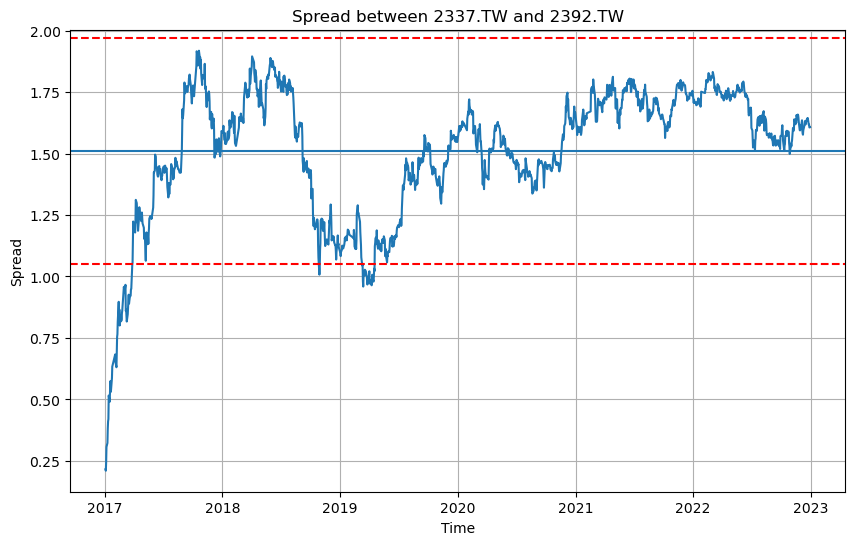

Statistics for the spread between 2337.TW and 2360.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

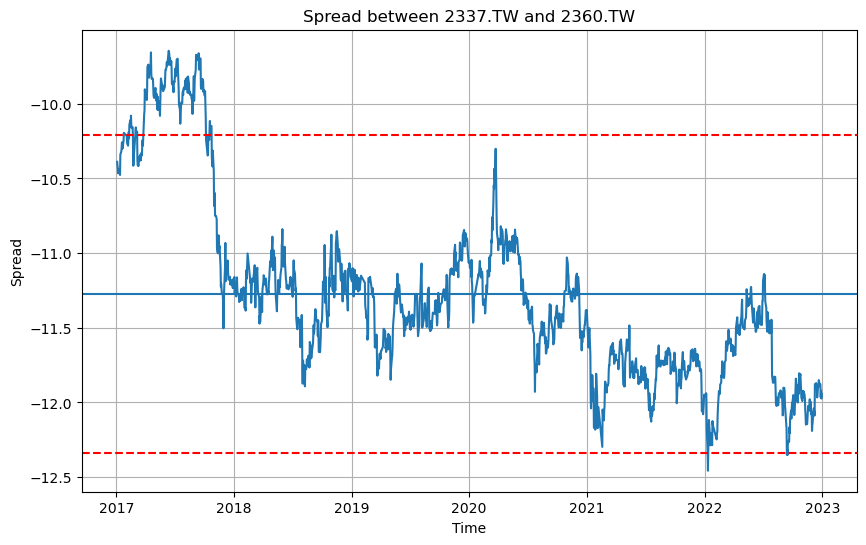

Statistics for the spread between 2337.TW and 3711.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.232665  -4.530681        -4.123517        -4.937844   
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
4   2385.TW  3044.TW    0.194506  -2.594393        -2.254008        -2.934778   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
6   2449.TW  6271.TW    1.019454 -19.543997       -17.759952       -21.328042   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
8   2376.TW  3443.TW    2.056596 -23.251594       -19.652550       -26.850637   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
10  2312.TW  3706.TW    0.260181  -3.434458        -2

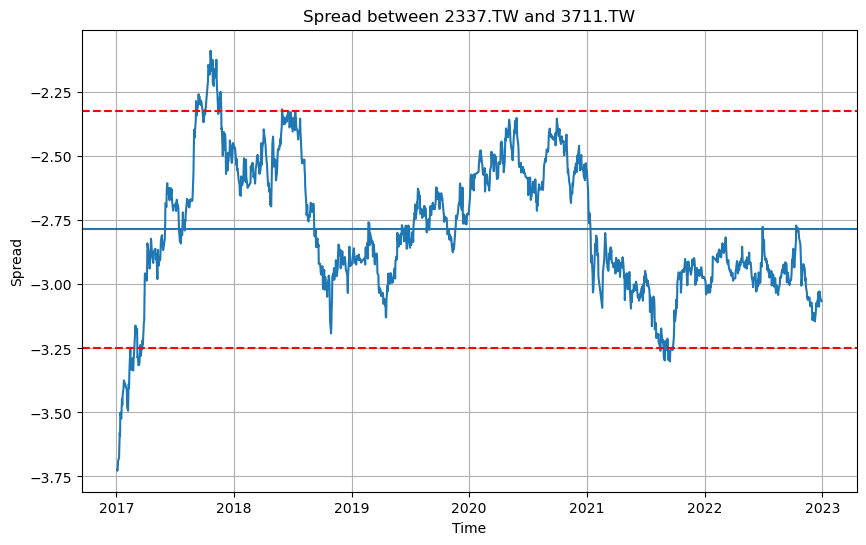

Statistics for the spread between 3231.TW and 3406.TW: 
   Ticker 1 Ticker 2  Volatility        Mean  90th Percentile  \
0   2324.TW  3702.TW    0.232665   -4.530681        -4.123517   
1   2344.TW  6116.TW    0.176941    1.655437         1.965085   
2   2385.TW  3706.TW    0.123593    2.962438         3.178726   
3   2382.TW  3380.TW    0.179069    2.853083         3.166453   
4   2385.TW  3044.TW    0.194506   -2.594393        -2.254008   
5   6271.TW  8150.TW    0.219125    4.221005         4.604474   
6   2449.TW  6271.TW    1.019454  -19.543997       -17.759952   
7   3231.TW  3380.TW    0.117169   -0.172974         0.032071   
8   2376.TW  3443.TW    2.056596  -23.251594       -19.652550   
9   2382.TW  6271.TW    0.429480   -7.580557        -6.828968   
10  2312.TW  3706.TW    0.260181   -3.434458        -2.979141   
11  8039.TW  6269.TW    0.237091   -5.587880        -5.172972   
12  2312.TW  3702.TW    0.474952   -8.276137        -7.444971   
13  2312.TW  3005.TW    0.453614  

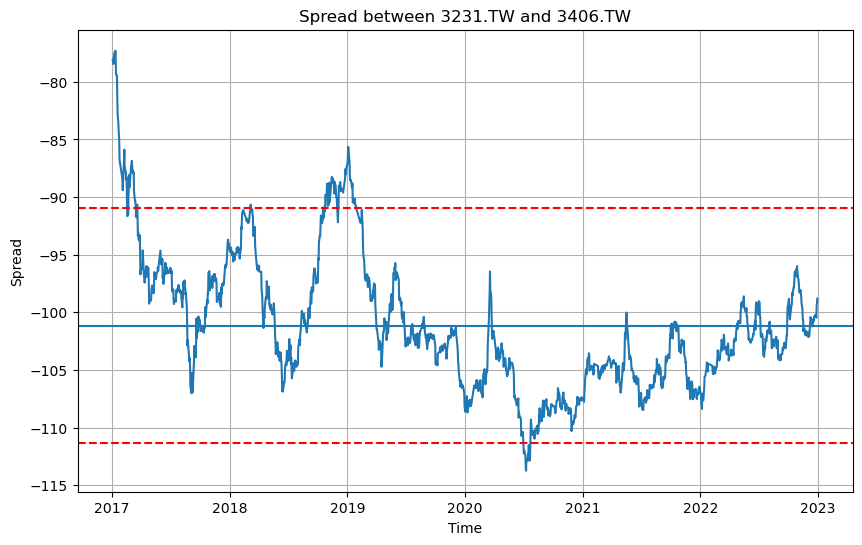

Statistics for the spread between 2337.TW and 2449.TW: 
   Ticker 1 Ticker 2  Volatility        Mean  90th Percentile  \
0   2324.TW  3702.TW    0.232665   -4.530681        -4.123517   
1   2344.TW  6116.TW    0.176941    1.655437         1.965085   
2   2385.TW  3706.TW    0.123593    2.962438         3.178726   
3   2382.TW  3380.TW    0.179069    2.853083         3.166453   
4   2385.TW  3044.TW    0.194506   -2.594393        -2.254008   
5   6271.TW  8150.TW    0.219125    4.221005         4.604474   
6   2449.TW  6271.TW    1.019454  -19.543997       -17.759952   
7   3231.TW  3380.TW    0.117169   -0.172974         0.032071   
8   2376.TW  3443.TW    2.056596  -23.251594       -19.652550   
9   2382.TW  6271.TW    0.429480   -7.580557        -6.828968   
10  2312.TW  3706.TW    0.260181   -3.434458        -2.979141   
11  8039.TW  6269.TW    0.237091   -5.587880        -5.172972   
12  2312.TW  3702.TW    0.474952   -8.276137        -7.444971   
13  2312.TW  3005.TW    0.453614  

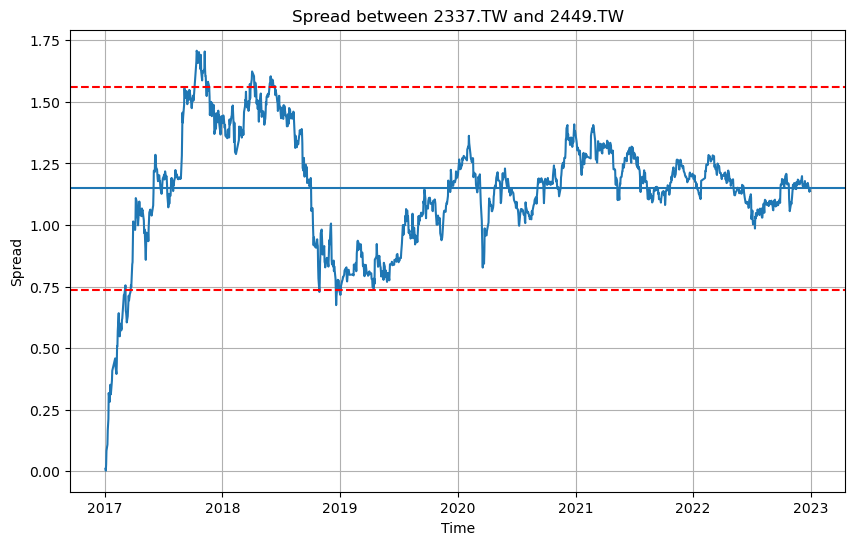

Statistics for the spread between 6239.TW and 3406.TW: 
   Ticker 1 Ticker 2  Volatility        Mean  90th Percentile  \
0   2324.TW  3702.TW    0.232665   -4.530681        -4.123517   
1   2344.TW  6116.TW    0.176941    1.655437         1.965085   
2   2385.TW  3706.TW    0.123593    2.962438         3.178726   
3   2382.TW  3380.TW    0.179069    2.853083         3.166453   
4   2385.TW  3044.TW    0.194506   -2.594393        -2.254008   
5   6271.TW  8150.TW    0.219125    4.221005         4.604474   
6   2449.TW  6271.TW    1.019454  -19.543997       -17.759952   
7   3231.TW  3380.TW    0.117169   -0.172974         0.032071   
8   2376.TW  3443.TW    2.056596  -23.251594       -19.652550   
9   2382.TW  6271.TW    0.429480   -7.580557        -6.828968   
10  2312.TW  3706.TW    0.260181   -3.434458        -2.979141   
11  8039.TW  6269.TW    0.237091   -5.587880        -5.172972   
12  2312.TW  3702.TW    0.474952   -8.276137        -7.444971   
13  2312.TW  3005.TW    0.453614  

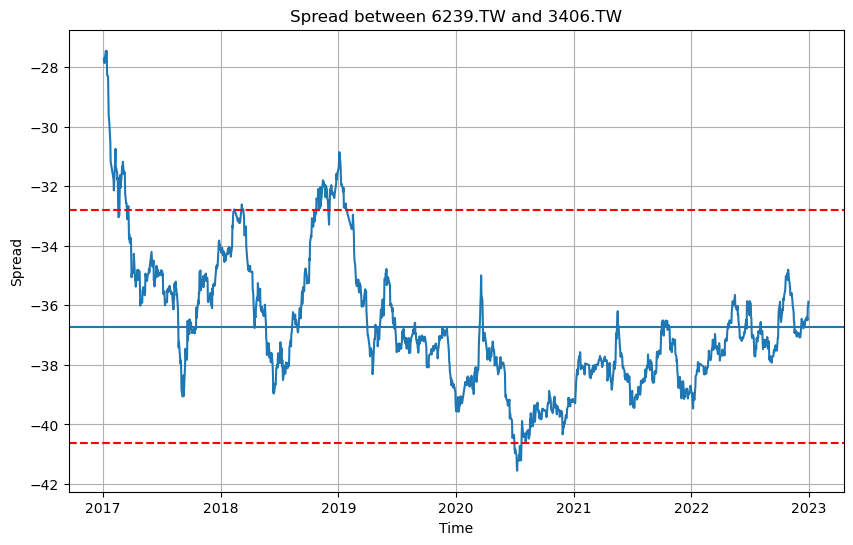

Statistics for the spread between 3406.TW and 4958.TW: 
   Ticker 1 Ticker 2  Volatility        Mean  90th Percentile  \
0   2324.TW  3702.TW    0.232665   -4.530681        -4.123517   
1   2344.TW  6116.TW    0.176941    1.655437         1.965085   
2   2385.TW  3706.TW    0.123593    2.962438         3.178726   
3   2382.TW  3380.TW    0.179069    2.853083         3.166453   
4   2385.TW  3044.TW    0.194506   -2.594393        -2.254008   
5   6271.TW  8150.TW    0.219125    4.221005         4.604474   
6   2449.TW  6271.TW    1.019454  -19.543997       -17.759952   
7   3231.TW  3380.TW    0.117169   -0.172974         0.032071   
8   2376.TW  3443.TW    2.056596  -23.251594       -19.652550   
9   2382.TW  6271.TW    0.429480   -7.580557        -6.828968   
10  2312.TW  3706.TW    0.260181   -3.434458        -2.979141   
11  8039.TW  6269.TW    0.237091   -5.587880        -5.172972   
12  2312.TW  3702.TW    0.474952   -8.276137        -7.444971   
13  2312.TW  3005.TW    0.453614  

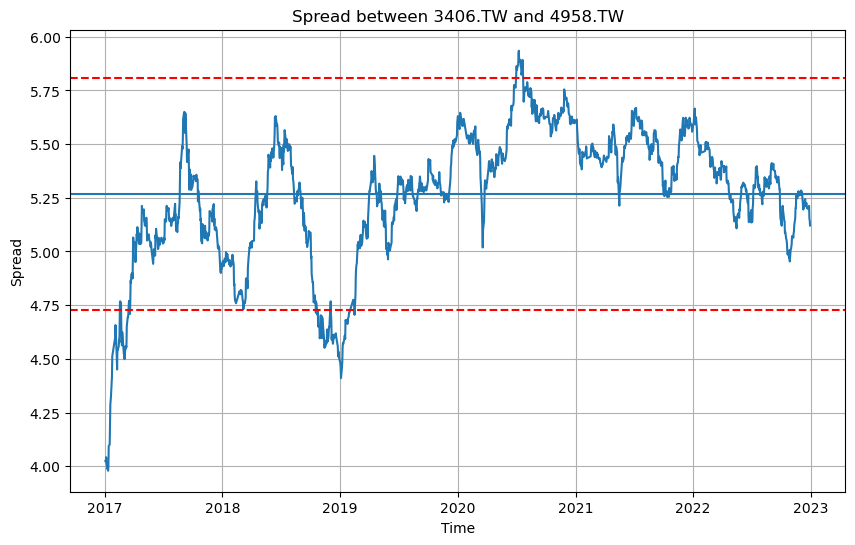

Statistics for the spread between 2337.TW and 6116.TW: 
   Ticker 1 Ticker 2  Volatility        Mean  90th Percentile  \
0   2324.TW  3702.TW    0.232665   -4.530681        -4.123517   
1   2344.TW  6116.TW    0.176941    1.655437         1.965085   
2   2385.TW  3706.TW    0.123593    2.962438         3.178726   
3   2382.TW  3380.TW    0.179069    2.853083         3.166453   
4   2385.TW  3044.TW    0.194506   -2.594393        -2.254008   
5   6271.TW  8150.TW    0.219125    4.221005         4.604474   
6   2449.TW  6271.TW    1.019454  -19.543997       -17.759952   
7   3231.TW  3380.TW    0.117169   -0.172974         0.032071   
8   2376.TW  3443.TW    2.056596  -23.251594       -19.652550   
9   2382.TW  6271.TW    0.429480   -7.580557        -6.828968   
10  2312.TW  3706.TW    0.260181   -3.434458        -2.979141   
11  8039.TW  6269.TW    0.237091   -5.587880        -5.172972   
12  2312.TW  3702.TW    0.474952   -8.276137        -7.444971   
13  2312.TW  3005.TW    0.453614  

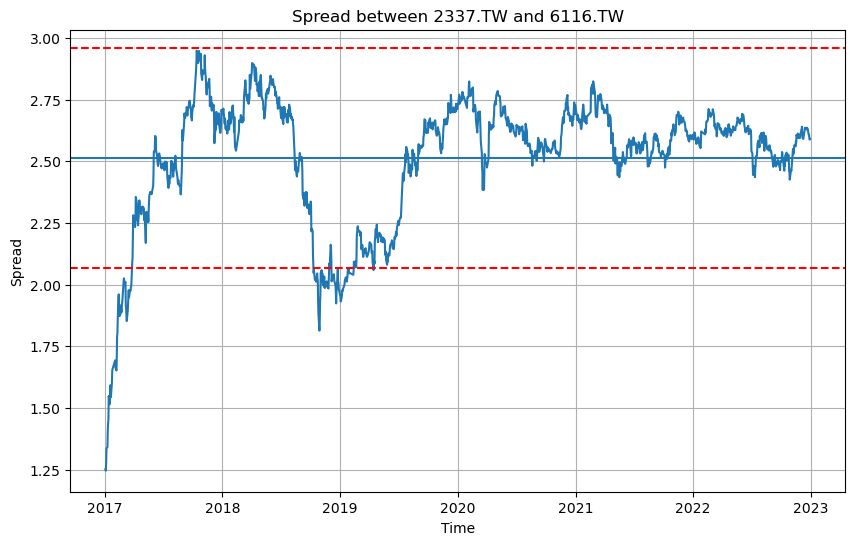

In [336]:
spread_calculator = Spread(merged_df)
Pairs = spread_calculator.calculate_spread_and_volatility(Pair)

### Selection based on number of days holding trade

#### Another criteria I added in is that I want to hold this long-short pair and realize profit as quick as possible ideally. Hence, I would set a threshold of 60 days at most. 

In [338]:
Filtered_Pairs = Pairs[Pairs['Revert Time'] <60]

In [340]:
Filtered_Pairs

Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
1   2344.TW  6116.TW    0.176941   1.655437         1.965085         1.345790   
2   2385.TW  3706.TW    0.123593   2.962438         3.178726         2.746149   
3   2382.TW  3380.TW    0.179069   2.853083         3.166453         2.539713   
5   6271.TW  8150.TW    0.219125   4.221005         4.604474         3.837537   
7   3231.TW  3380.TW    0.117169  -0.172974         0.032071        -0.378019   
9   2382.TW  6271.TW    0.429480  -7.580557        -6.828968        -8.332146   
11  8039.TW  6269.TW    0.237091  -5.587880        -5.172972        -6.002789   
14  6239.TW  8039.TW    0.117554   2.771496         2.977216         2.565776   
18  2312.TW  2385.TW    0.697176 -15.461511       -14.241453       -16.681569   
22  2337.TW  2441.TW    0.240822  -1.204661        -0.783222        -1.626099   
23  2337.TW  2313.TW    0.198579   0.234423         0.581936        -0.113090   
24  2337.TW  2392.TW    0.263026   1.511216         1.971511         1.050921   
26  2337.TW  3711.TW    0.264053  -2.784932        -2.322840        -3.247024   

    Revert Time  
1     46.854167  
2     39.274510  
3     58.027778  
5     49.688889  
7     41.553571  
9     58.268293  
11    55.880000  
14    58.555556  
18    44.931818  
22    44.142857  
23    52.791667  
24    50.868421  
26    56.325581

### Calculate hedging ratio 

In [342]:
FPairs= Filtered_Pairs[['Ticker 1', 'Ticker 2']].apply(pd.Series)

In [344]:
FPairs=FPairs[['Ticker 1', 'Ticker 2']]

In [346]:
FPairs

Ticker 1 Ticker 2
1   2344.TW  6116.TW
2   2385.TW  3706.TW
3   2382.TW  3380.TW
5   6271.TW  8150.TW
7   3231.TW  3380.TW
9   2382.TW  6271.TW
11  8039.TW  6269.TW
14  6239.TW  8039.TW
18  2312.TW  2385.TW
22  2337.TW  2441.TW
23  2337.TW  2313.TW
24  2337.TW  2392.TW
26  2337.TW  3711.TW

In [348]:
import Hedge


# Now you can use the reloaded Hedge_ratio class
hedge_ratio_instance = Hedge.Hedge_ratio(FPairs, merged_df)
HR = hedge_ratio_instance.hedge(FPairs, merged_df)

### Backtest with signal 

#### Our signal will be when it hit the standard deviation then we will take position and unwind when it reaches the mean.

#### Assumption
1. Our price will be closing price
2. Not considering transaction cost
3. No borrowing cost consider might use SSF in TW to carry out this trade, assuming SSF same price and closing price 

In [352]:
from Backtest import Backtest
Backtest = Backtest(FPairs,merged_df,HR)

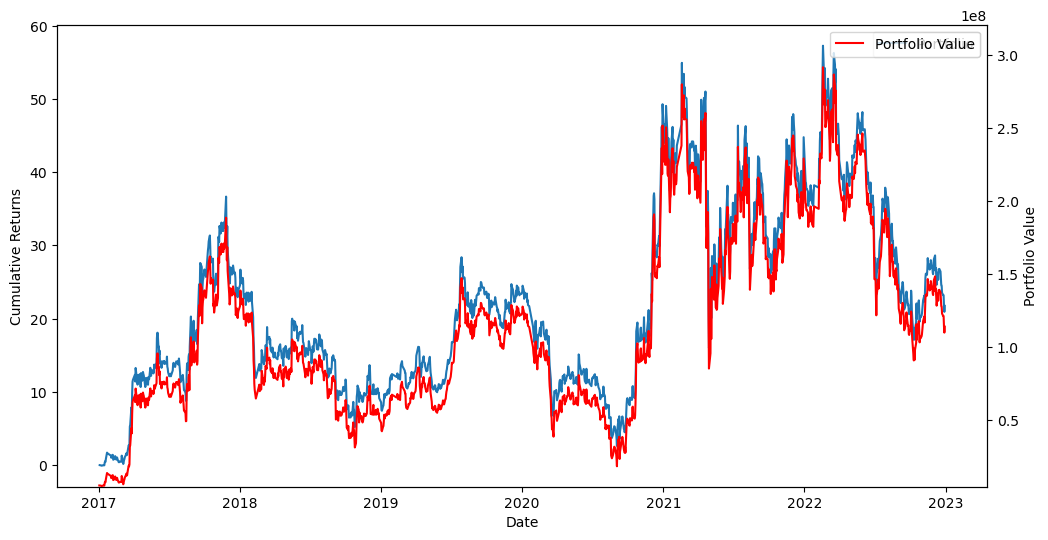

Sharpe Ratio: 1.032
CAGR: 68.45%
max drawdown: -5438.20%


2344.TW    Spread Signal    6116.TW  2344.TW's trade  \
Date                                                                 
2017-01-03   7.772441  1.039672    Buy   6.160337         321649.0   
2017-01-04   7.811112  1.043239    Buy   6.175816         320057.0   
2017-01-05   7.888449  1.044107    Buy   6.276424         316919.0   
2017-01-06   7.811112  1.034255    Buy   6.276424         320057.0   
2017-01-09   7.733774  1.009422    Buy   6.446685         323257.0   
...               ...       ...    ...        ...              ...   
2022-12-26  19.122204  1.612547    NaN  11.100000              0.0   
2022-12-27  19.170010  1.612545    NaN  11.150000              0.0   
2022-12-28  18.596344  1.589694    NaN  11.000000              0.0   
2022-12-29  18.596344  1.577198    NaN  11.250000              0.0   
2022-12-30  18.739759  1.589845    NaN  11.150000              0.0   

            6116.TW's trade  2344.TW's position  6116.TW's position  \
Date                                                                  
2017-01-03        -321649.0            321649.0           -321649.0   
2017-01-04        -320057.0            641706.0           -641706.0   
2017-01-05        -316919.0            958625.0           -958625.0   
2017-01-06        -320057.0           1278682.0          -1278682.0   
2017-01-09        -323257.0           1601939.0          -1601939.0   
...                     ...                 ...                 ...   
2022-12-26              0.0          16858280.0         -16858280.0   
2022-12-27              0.0          16858280.0         -16858280.0   
2022-12-28              0.0          16858280.0         -16858280.0   
2022-12-29              0.0          16858280.0         -16858280.0   
2022-12-30              0.0          16858280.0         -16858280.0   

                    Cash  Position MTM  Portfolio Value   returns  cum returns  
Date                                                                            
2017-01-03  4.481468e+06  5.185316e+05     5.000000e+06       NaN          NaN  
2017-01-04  3.958080e+06  1.049379e+06     5.007460e+06  0.001492     0.001492  
2017-01-05  3.447199e+06  1.545328e+06     4.992527e+06 -0.002982    -0.001495  
2017-01-06  2.956011e+06  1.962378e+06     4.918389e+06 -0.014850    -0.016322  
2017-01-09  2.539951e+06  2.061837e+06     4.601788e+06 -0.064371    -0.079642  
...                  ...           ...              ...       ...          ...  
2022-12-26 -1.418984e+07  1.352406e+08     1.210507e+08 -0.013140    23.210142  
2022-12-27 -1.418984e+07  1.352036e+08     1.210137e+08 -0.000305    23.202747  
2022-12-28 -1.418984e+07  1.280613e+08     1.138715e+08 -0.059020    21.774291  
2022-12-29 -1.418984e+07  1.238467e+08     1.096569e+08 -0.037012    20.931377  
2022-12-30 -1.418984e+07  1.279503e+08     1.137605e+08  0.037422    21.752091  

[1465 rows x 13 columns]

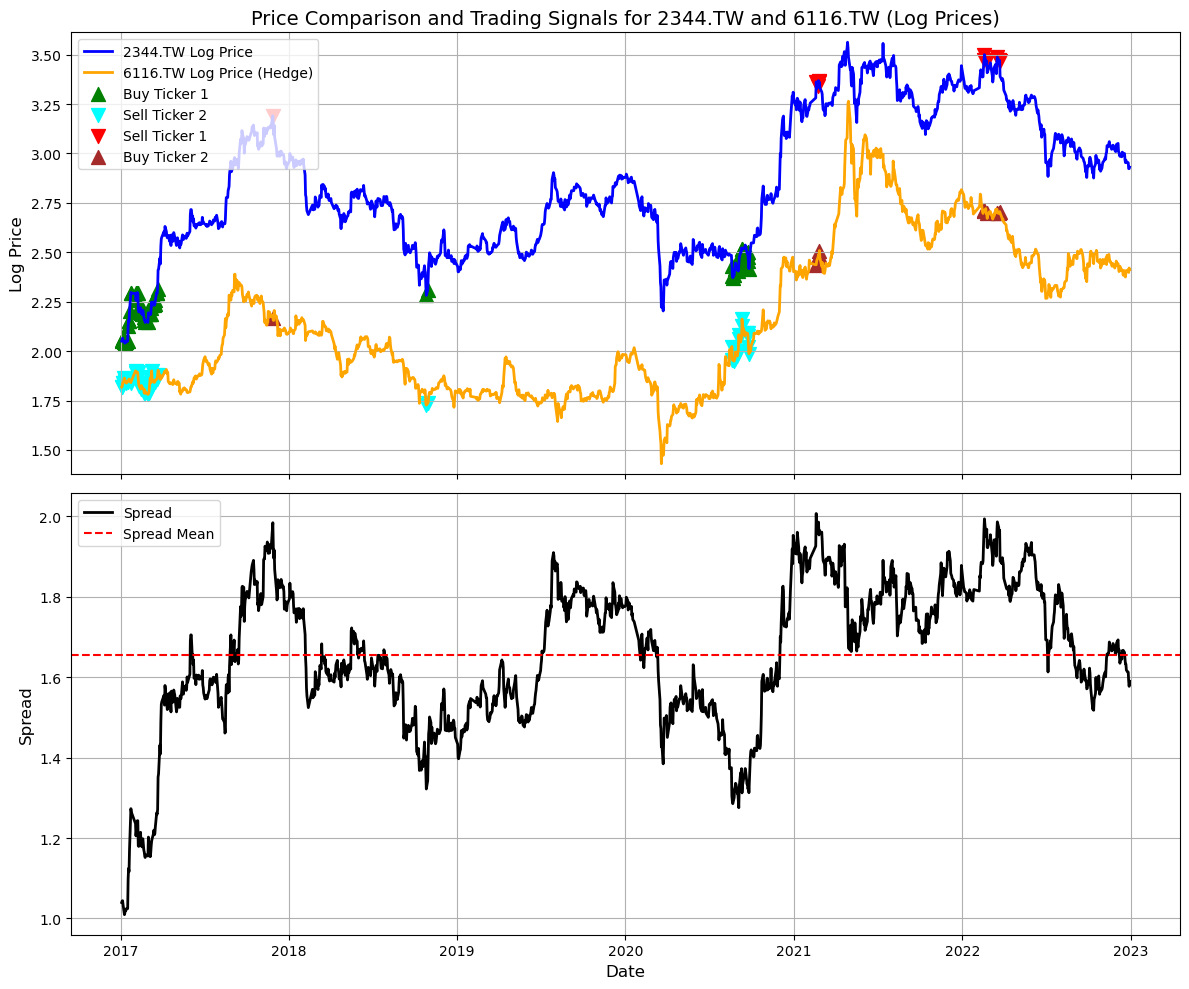

Results saved for 2344.TW and 6116.TW to 2344.TW_6116.TW_results.csv


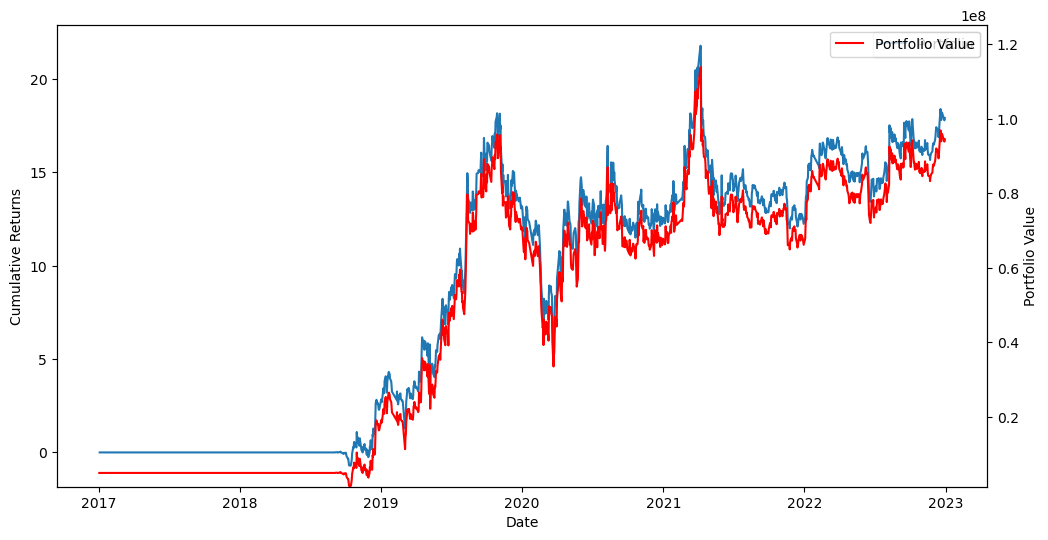

Sharpe Ratio: 0.979
CAGR: 63.33%
max drawdown: nan%


2385.TW    Spread Signal    3706.TW  2385.TW's trade  \
Date                                                                 
2017-01-03  45.554295  2.849951    NaN  14.396784              0.0   
2017-01-04  45.432163  2.835676    NaN  14.863451              0.0   
2017-01-05  45.554295  2.837791    NaN  14.886785              0.0   
2017-01-06  45.065777  2.827009    NaN  14.886785              0.0   
2017-01-09  44.882584  2.824077    NaN  14.840115              0.0   
...               ...       ...    ...        ...              ...   
2022-12-26  77.092010  3.140185    NaN  27.555494              0.0   
2022-12-27  77.002884  3.138414    NaN  27.602123              0.0   
2022-12-28  76.557266  3.138175    NaN  27.182493              0.0   
2022-12-29  76.824638  3.134871    NaN  27.695374              0.0   
2022-12-30  76.913757  3.138485    NaN  27.508871              0.0   

            3706.TW's trade  2385.TW's position  3706.TW's position  \
Date                                                                  
2017-01-03              0.0                 0.0                 0.0   
2017-01-04              0.0                 0.0                 0.0   
2017-01-05              0.0                 0.0                 0.0   
2017-01-06              0.0                 0.0                 0.0   
2017-01-09              0.0                 0.0                 0.0   
...                     ...                 ...                 ...   
2022-12-26              0.0           2343896.0          -2343896.0   
2022-12-27              0.0           2343896.0          -2343896.0   
2022-12-28              0.0           2343896.0          -2343896.0   
2022-12-29              0.0           2343896.0          -2343896.0   
2022-12-30              0.0           2343896.0          -2343896.0   

                    Cash  Position MTM  Portfolio Value   returns  cum returns  
Date                                                                            
2017-01-03  5.000000e+06  0.000000e+00     5.000000e+06       NaN          NaN  
2017-01-04  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-05  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-06  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-09  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
...                  ...           ...              ...       ...          ...  
2022-12-26 -2.124716e+07  1.161084e+08     9.486128e+07 -0.011817    17.972256  
2022-12-27 -2.124716e+07  1.157902e+08     9.454308e+07 -0.003354    17.908616  
2022-12-28 -2.124716e+07  1.157293e+08     9.448217e+07 -0.000644    17.896434  
2022-12-29 -2.124716e+07  1.151539e+08     9.390672e+07 -0.006091    17.781345  
2022-12-30 -2.124716e+07  1.157999e+08     9.455275e+07  0.006879    17.910550  

[1465 rows x 13 columns]

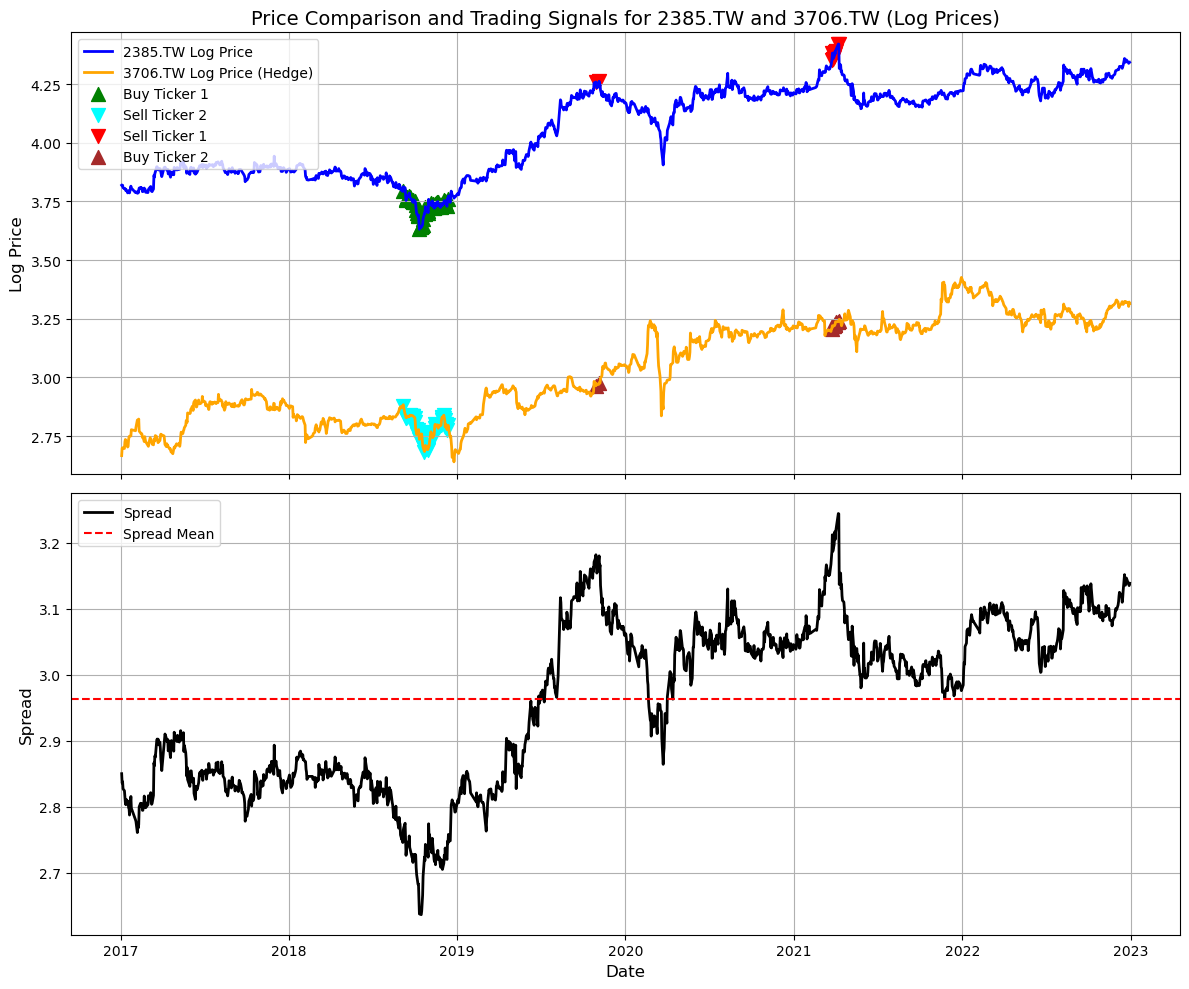

Results saved for 2385.TW and 3706.TW to 2385.TW_3706.TW_results.csv


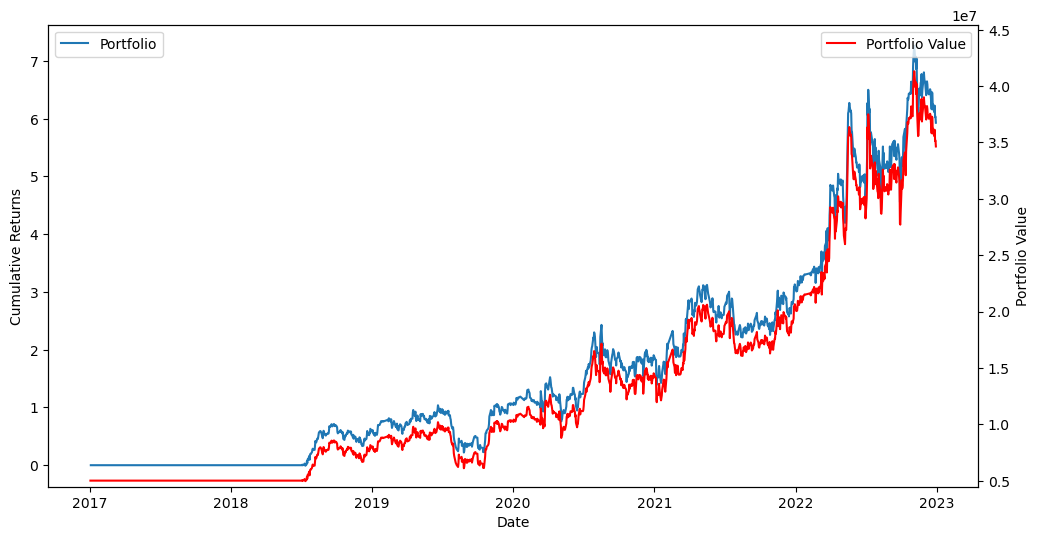

Sharpe Ratio: 0.957
CAGR: 38.13%
max drawdown: nan%


2382.TW    Spread Signal    3380.TW  2382.TW's trade  \
Date                                                                 
2017-01-03  37.951733  2.675584    NaN  14.974221              0.0   
2017-01-04  37.951733  2.672052    NaN  15.123964              0.0   
2017-01-05  37.951733  2.665091    NaN  15.423450              0.0   
2017-01-06  38.204746  2.673463    NaN  15.348577              0.0   
2017-01-09  38.963772  2.702790    NaN  14.936788              0.0   
...               ...       ...    ...        ...              ...   
2022-12-26  64.766739  3.005019    NaN  26.680269              0.0   
2022-12-27  64.766739  2.998834    NaN  27.149168              0.0   
2022-12-28  64.857071  3.010176    NaN  26.398932              0.0   
2022-12-29  64.766739  3.009413    NaN  26.352041              0.0   
2022-12-30  65.308723  3.016486    NaN  26.445822              0.0   

            3380.TW's trade  2382.TW's position  3380.TW's position  \
Date                                                                  
2017-01-03              0.0                 0.0                 0.0   
2017-01-04              0.0                 0.0                 0.0   
2017-01-05              0.0                 0.0                 0.0   
2017-01-06              0.0                 0.0                 0.0   
2017-01-09              0.0                 0.0                 0.0   
...                     ...                 ...                 ...   
2022-12-26              0.0          -1186376.0           1186376.0   
2022-12-27              0.0          -1186376.0           1186376.0   
2022-12-28              0.0          -1186376.0           1186376.0   
2022-12-29              0.0          -1186376.0           1186376.0   
2022-12-30              0.0          -1186376.0           1186376.0   

                    Cash  Position MTM  Portfolio Value   returns  cum returns  
Date                                                                            
2017-01-03  5.000000e+06  0.000000e+00     5.000000e+06       NaN          NaN  
2017-01-04  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-05  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-06  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-09  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
...                  ...           ...              ...       ...          ...  
2022-12-26  8.074787e+07 -4.518487e+07     3.556300e+07 -0.017870     6.112600  
2022-12-27  8.074787e+07 -4.462858e+07     3.611929e+07  0.015642     6.223858  
2022-12-28  8.074787e+07 -4.562581e+07     3.512206e+07 -0.027609     6.024412  
2022-12-29  8.074787e+07 -4.557428e+07     3.517360e+07  0.001467     6.034719  
2022-12-30  8.074787e+07 -4.610601e+07     3.464186e+07 -0.015118     5.928372  

[1465 rows x 13 columns]

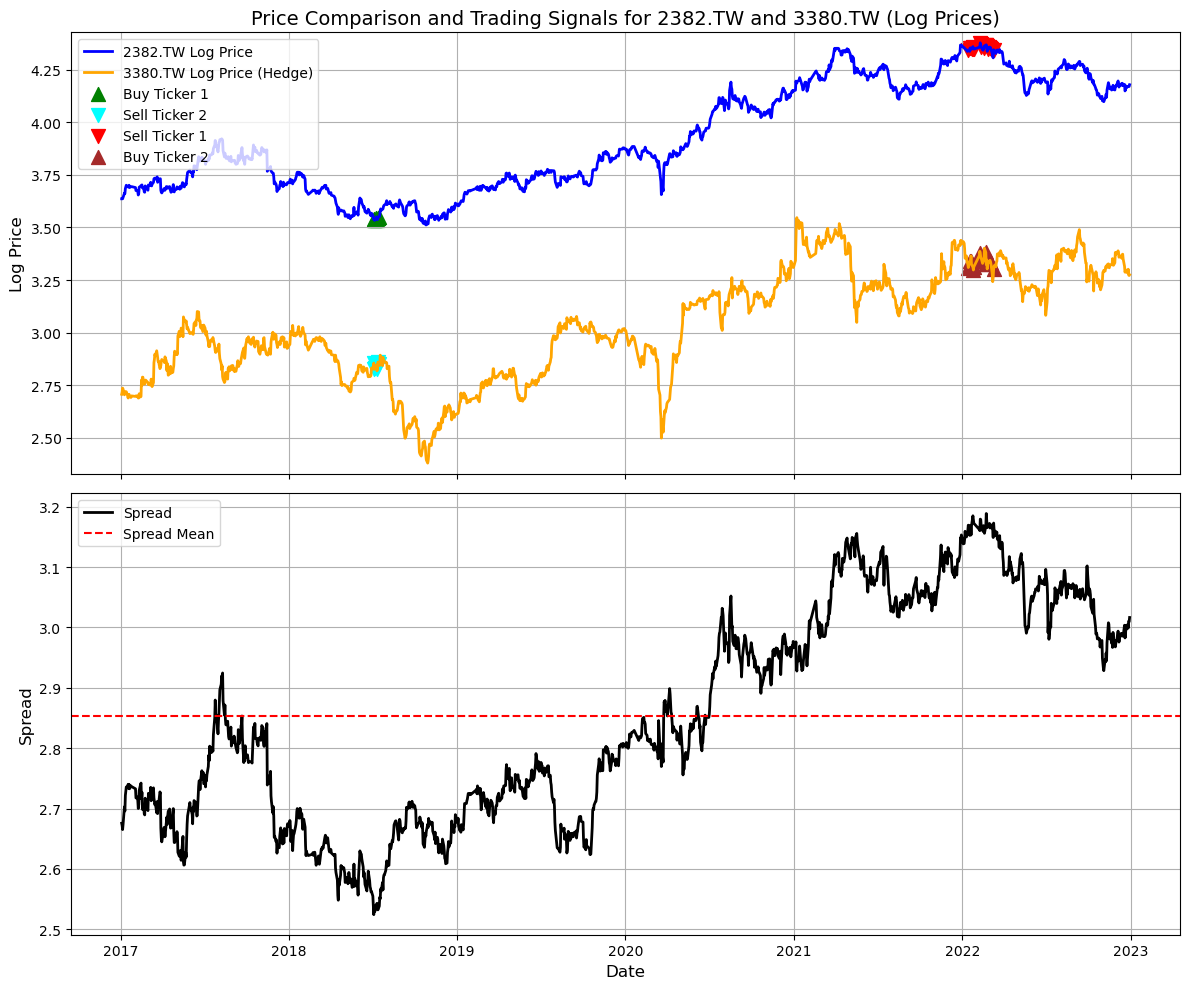

Results saved for 2382.TW and 3380.TW to 2382.TW_3380.TW_results.csv


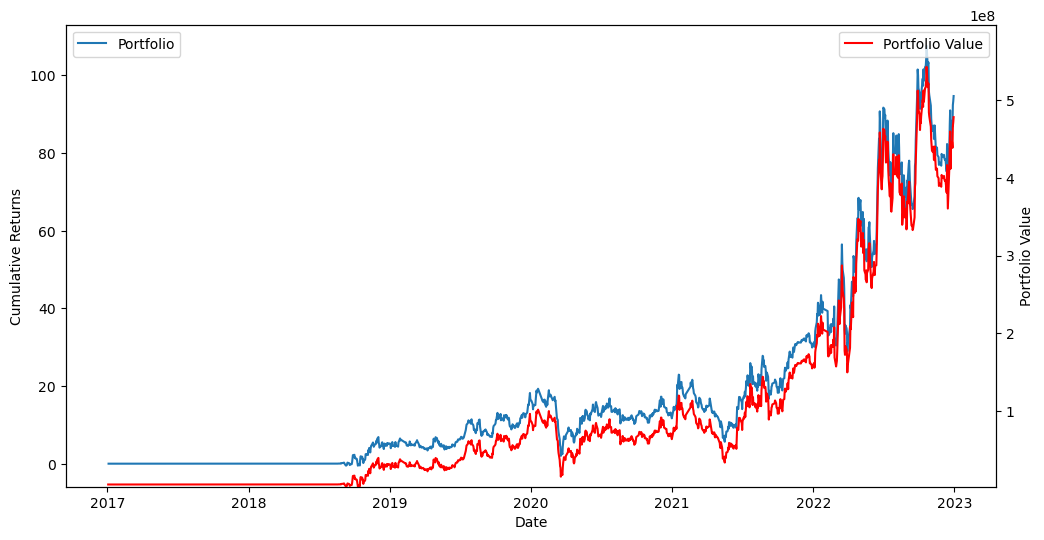

Sharpe Ratio: 1.080
CAGR: 114.08%
max drawdown: nan%


6271.TW    Spread Signal    8150.TW  6271.TW's trade  \
Date                                                                  
2017-01-03   89.559753  3.924436    NaN  18.956898              0.0   
2017-01-04   92.036057  3.954876    NaN  18.649900              0.0   
2017-01-05   90.385178  3.930109    NaN  19.302265              0.0   
2017-01-06   90.385178  3.922549    NaN  20.069750              0.0   
2017-01-09   88.321594  3.902066    NaN  19.801132              0.0   
...                ...       ...    ...        ...              ...   
2022-12-26  145.065048  4.319239    NaN  29.764128              0.0   
2022-12-27  146.515701  4.330963    NaN  29.493134              0.0   
2022-12-28  139.987778  4.287475    NaN  29.176975              0.0   
2022-12-29  139.262451  4.280191    NaN  29.493134              0.0   
2022-12-30  138.537125  4.269986    NaN  30.260950              0.0   

            8150.TW's trade  6271.TW's position  8150.TW's position  \
Date                                                                  
2017-01-03              0.0                 0.0                 0.0   
2017-01-04              0.0                 0.0                 0.0   
2017-01-05              0.0                 0.0                 0.0   
2017-01-06              0.0                 0.0                 0.0   
2017-01-09              0.0                 0.0                 0.0   
...                     ...                 ...                 ...   
2022-12-26              0.0          -4525992.0           4525992.0   
2022-12-27              0.0          -4525992.0           4525992.0   
2022-12-28              0.0          -4525992.0           4525992.0   
2022-12-29              0.0          -4525992.0           4525992.0   
2022-12-30              0.0          -4525992.0           4525992.0   

                    Cash  Position MTM  Portfolio Value   returns  cum returns  
Date                                                                            
2017-01-03  5.000000e+06  0.000000e+00     5.000000e+06       NaN          NaN  
2017-01-04  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-05  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-06  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-09  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
...                  ...           ...              ...       ...          ...  
2022-12-26  9.683380e+08 -5.218510e+08     4.464870e+08  0.007872    88.297401  
2022-12-27  9.683380e+08 -5.296432e+08     4.386948e+08 -0.017452    86.738969  
2022-12-28  9.683380e+08 -5.015288e+08     4.668092e+08  0.064086    92.361849  
2022-12-29  9.683380e+08 -4.968151e+08     4.715230e+08  0.010098    93.304599  
2022-12-30  9.683380e+08 -4.900571e+08     4.782809e+08  0.014332    94.656190  

[1465 rows x 13 columns]

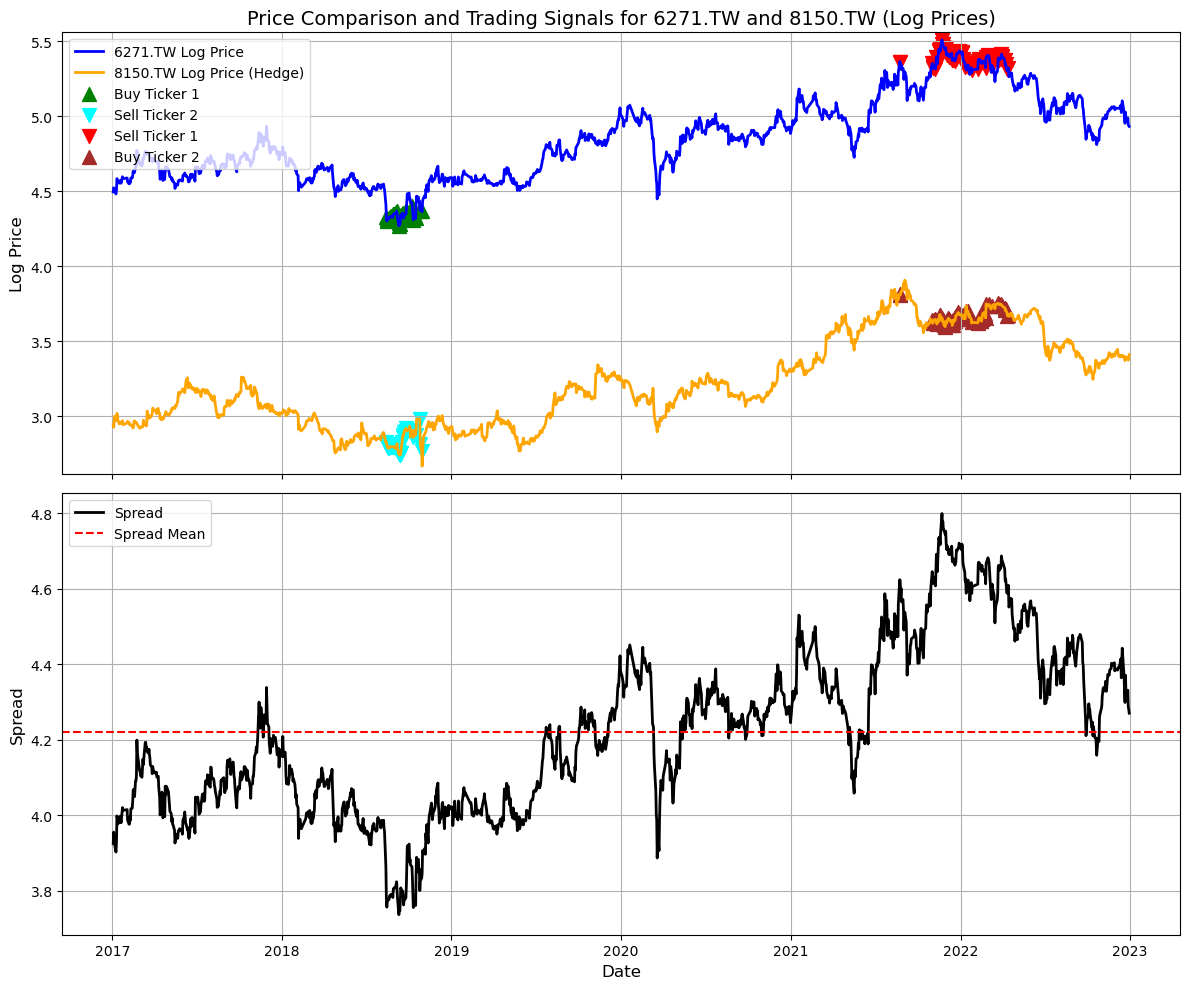

Results saved for 6271.TW and 8150.TW to 6271.TW_8150.TW_results.csv


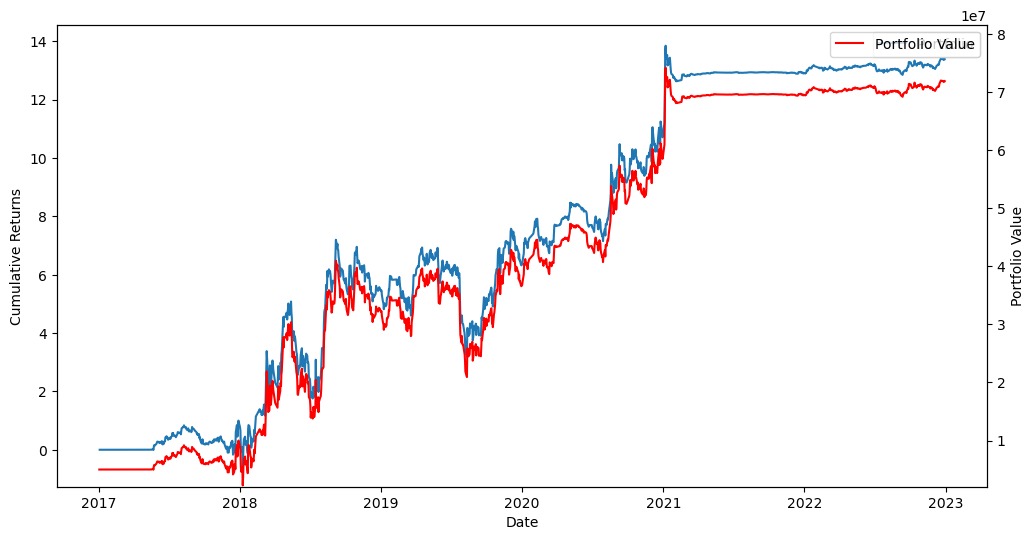

Sharpe Ratio: 0.911
CAGR: 56.04%
max drawdown: nan%


3231.TW    Spread Signal    3380.TW  3231.TW's trade  \
Date                                                                 
2017-01-03  15.547924 -0.100289    NaN  14.974221              0.0   
2017-01-04  15.392446 -0.120797    NaN  15.123964              0.0   
2017-01-05  15.205870 -0.153600    NaN  15.423450              0.0   
2017-01-06  15.610116 -0.122248    NaN  15.348577              0.0   
2017-01-09  15.547924 -0.097659    NaN  14.936788              0.0   
...               ...       ...    ...        ...              ...   
2022-12-26  28.232948 -0.110749    NaN  26.680269              0.0   
2022-12-27  28.280560 -0.127374    NaN  27.149168              0.0   
2022-12-28  27.899673 -0.111483    NaN  26.398932              0.0   
2022-12-29  28.042507 -0.104508    NaN  26.352041              0.0   
2022-12-30  27.994896 -0.109941    NaN  26.445822              0.0   

            3380.TW's trade  3231.TW's position  3380.TW's position  \
Date                                                                  
2017-01-03              0.0                 0.0                 0.0   
2017-01-04              0.0                 0.0                 0.0   
2017-01-05              0.0                 0.0                 0.0   
2017-01-06              0.0                 0.0                 0.0   
2017-01-09              0.0                 0.0                 0.0   
...                     ...                 ...                 ...   
2022-12-26              0.0            326813.0           -326813.0   
2022-12-27              0.0            326813.0           -326813.0   
2022-12-28              0.0            326813.0           -326813.0   
2022-12-29              0.0            326813.0           -326813.0   
2022-12-30              0.0            326813.0           -326813.0   

                    Cash   Position MTM  Portfolio Value   returns  \
Date                                                                 
2017-01-03  5.000000e+06       0.000000     5.000000e+06       NaN   
2017-01-04  5.000000e+06       0.000000     5.000000e+06  0.000000   
2017-01-05  5.000000e+06       0.000000     5.000000e+06  0.000000   
2017-01-06  5.000000e+06       0.000000     5.000000e+06  0.000000   
2017-01-09  5.000000e+06       0.000000     5.000000e+06  0.000000   
...                  ...            ...              ...       ...   
2022-12-26  7.141098e+07  507435.702253     7.191841e+07 -0.000655   
2022-12-27  7.141098e+07  369753.458548     7.178073e+07 -0.001914   
2022-12-28  7.141098e+07  490461.981722     7.190144e+07  0.001682   
2022-12-29  7.141098e+07  552466.241041     7.196344e+07  0.000862   
2022-12-30  7.141098e+07  506257.577692     7.191724e+07 -0.000642   

            cum returns  
Date                     
2017-01-03          NaN  
2017-01-04     0.000000  
2017-01-05     0.000000  
2017-01-06     0.000000  
2017-01-09     0.000000  
...                 ...  
2022-12-26    13.383683  
2022-12-27    13.356146  
2022-12-28    13.380288  
2022-12-29    13.392689  
2022-12-30    13.383447  

[1465 rows x 13 columns]

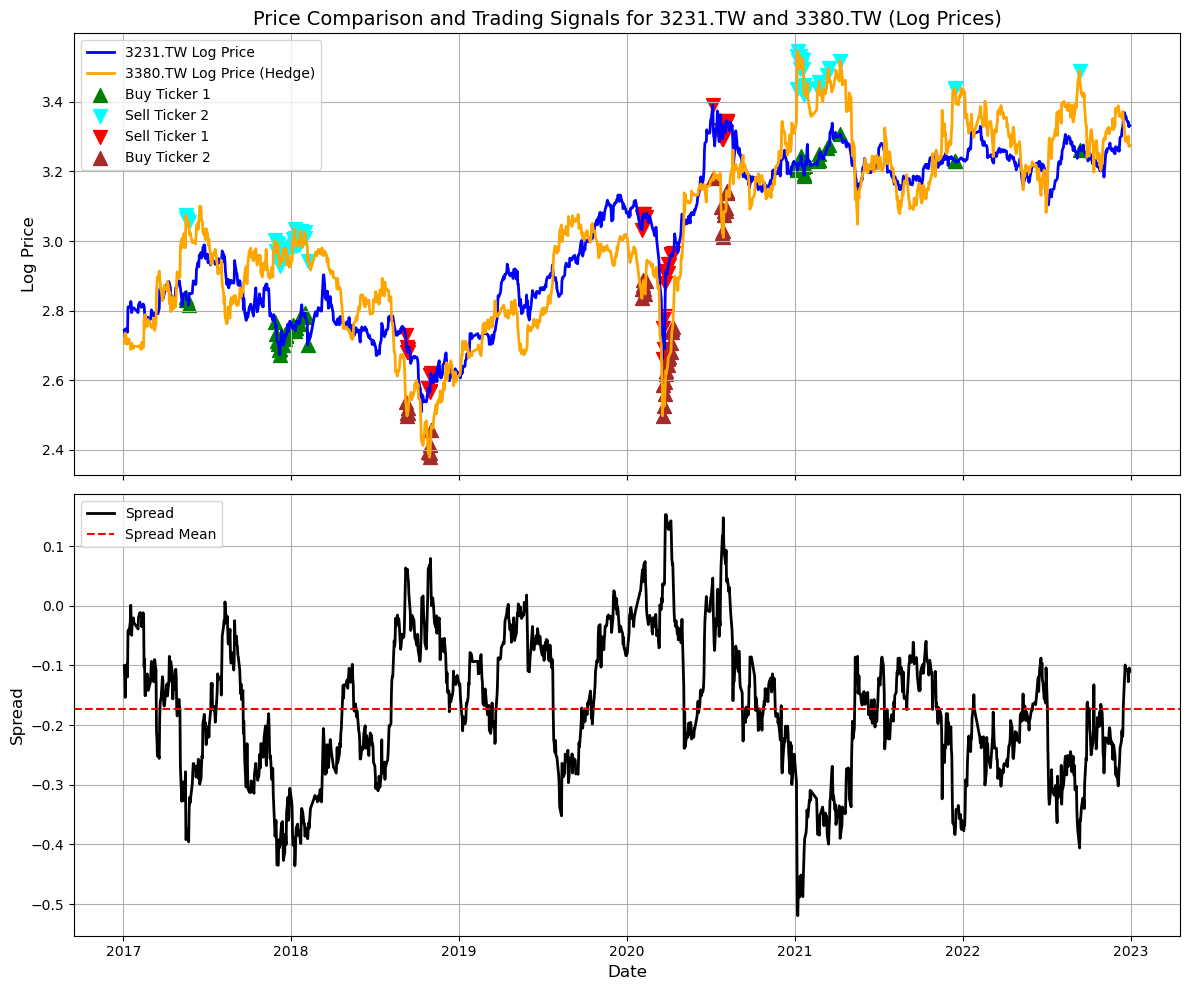

Results saved for 3231.TW and 3380.TW to 3231.TW_3380.TW_results.csv


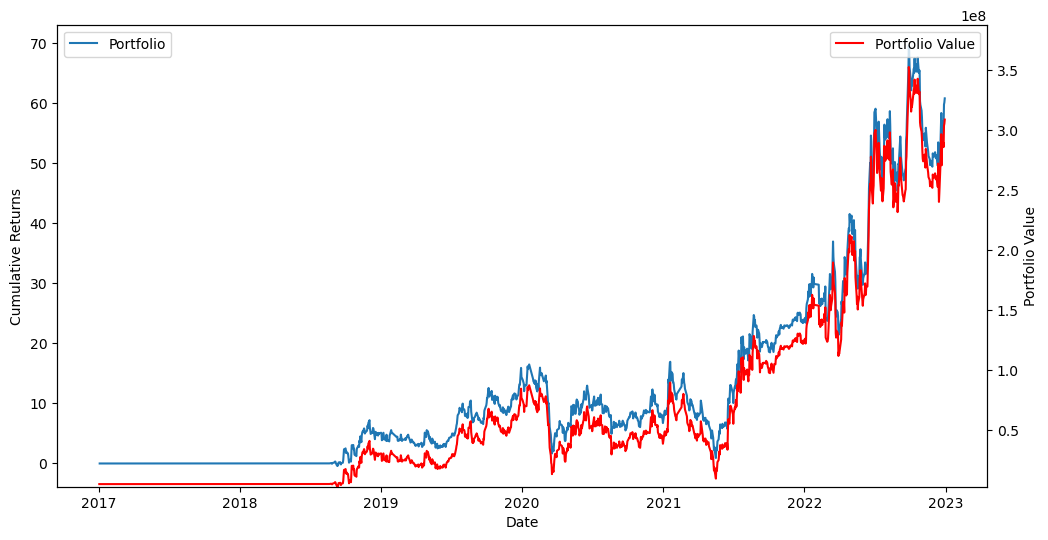

Sharpe Ratio: 1.141
CAGR: 99.01%
max drawdown: nan%


2382.TW    Spread Signal     6271.TW  2382.TW's trade  \
Date                                                                  
2017-01-03  37.951733 -7.042979    NaN   89.559753              0.0   
2017-01-04  37.951733 -7.107779    NaN   92.036057              0.0   
2017-01-05  37.951733 -7.064776    NaN   90.385178              0.0   
2017-01-06  38.204746 -7.058131    NaN   90.385178              0.0   
2017-01-09  38.963772 -6.983586    NaN   88.321594              0.0   
...               ...       ...    ...         ...              ...   
2022-12-26  64.766739 -7.654325    NaN  145.065048              0.0   
2022-12-27  64.766739 -7.677966    NaN  146.515701              0.0   
2022-12-28  64.857071 -7.568286    NaN  139.987778              0.0   
2022-12-29  64.766739 -7.557338    NaN  139.262451              0.0   
2022-12-30  65.308723 -7.536598    NaN  138.537125              0.0   

            6271.TW's trade  2382.TW's position  6271.TW's position  \
Date                                                                  
2017-01-03              0.0                 0.0                 0.0   
2017-01-04              0.0                 0.0                 0.0   
2017-01-05              0.0                 0.0                 0.0   
2017-01-06              0.0                 0.0                 0.0   
2017-01-09              0.0                 0.0                 0.0   
...                     ...                 ...                 ...   
2022-12-26              0.0           2692787.0          -2692787.0   
2022-12-27              0.0           2692787.0          -2692787.0   
2022-12-28              0.0           2692787.0          -2692787.0   
2022-12-29              0.0           2692787.0          -2692787.0   
2022-12-30              0.0           2692787.0          -2692787.0   

                    Cash  Position MTM  Portfolio Value   returns  cum returns  
Date                                                                            
2017-01-03  5.000000e+06  0.000000e+00     5.000000e+06       NaN          NaN  
2017-01-04  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-05  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-06  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-09  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
...                  ...           ...              ...       ...          ...  
2022-12-26  5.060610e+08 -2.162262e+08     2.898348e+08  0.011056    56.966957  
2022-12-27  5.060610e+08 -2.201325e+08     2.859285e+08 -0.013478    56.185697  
2022-12-28  5.060610e+08 -2.023110e+08     3.037500e+08  0.062329    59.750007  
2022-12-29  5.060610e+08 -2.006011e+08     3.054599e+08  0.005629    60.091988  
2022-12-30  5.060610e+08 -1.971885e+08     3.088725e+08  0.011172    60.774508  

[1465 rows x 13 columns]

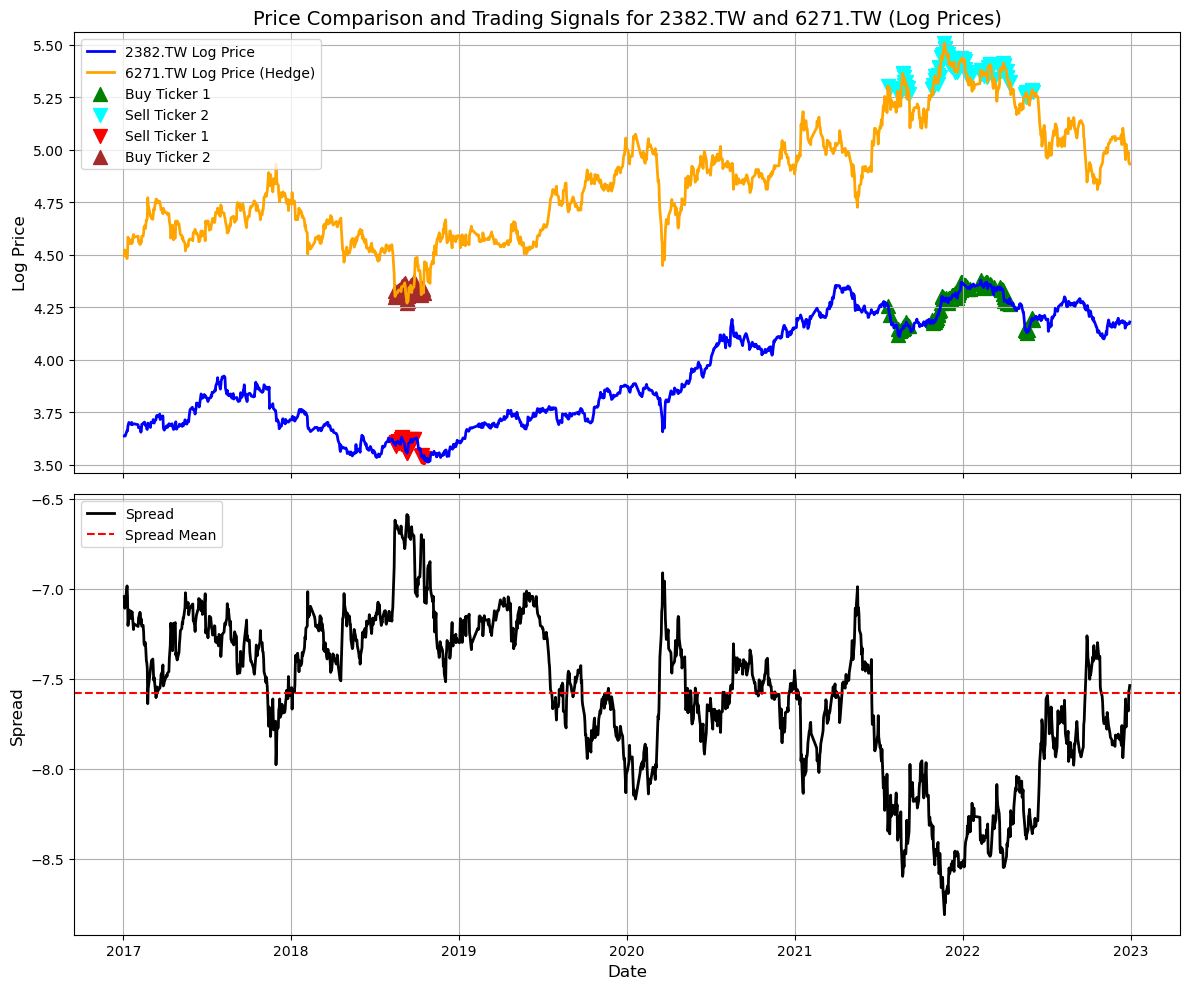

Results saved for 2382.TW and 6271.TW to 2382.TW_6271.TW_results.csv


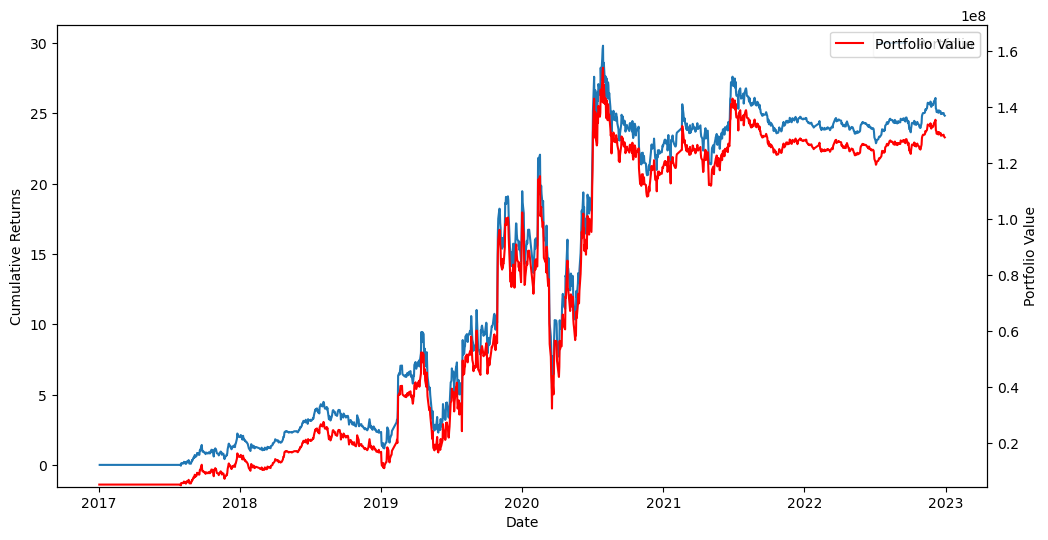

Sharpe Ratio: 1.040
CAGR: 72.06%
max drawdown: nan%


8039.TW    Spread Signal    6269.TW  8039.TW's trade  \
Date                                                                 
2017-01-03  22.923454 -5.267726    NaN  57.503399              0.0   
2017-01-04  23.387897 -5.259757    NaN  57.839691              0.0   
2017-01-05  23.354723 -5.263585    NaN  57.906940              0.0   
2017-01-06  23.951859 -5.259896    NaN  58.512245              0.0   
2017-01-09  24.283602 -5.265116    NaN  59.050278              0.0   
...               ...       ...    ...        ...              ...   
2022-12-26  36.368538 -5.725748    NaN  89.605217              0.0   
2022-12-27  36.324188 -5.731131    NaN  89.785324              0.0   
2022-12-28  36.146774 -5.704600    NaN  88.434494              0.0   
2022-12-29  36.191132 -5.697030    NaN  88.164330              0.0   
2022-12-30  36.545944 -5.689391    NaN  88.254387              0.0   

            6269.TW's trade  8039.TW's position  6269.TW's position  \
Date                                                                  
2017-01-03              0.0                 0.0                 0.0   
2017-01-04              0.0                 0.0                 0.0   
2017-01-05              0.0                 0.0                 0.0   
2017-01-06              0.0                 0.0                 0.0   
2017-01-09              0.0                 0.0                 0.0   
...                     ...                 ...                 ...   
2022-12-26              0.0           -540146.0            540146.0   
2022-12-27              0.0           -540146.0            540146.0   
2022-12-28              0.0           -540146.0            540146.0   
2022-12-29              0.0           -540146.0            540146.0   
2022-12-30              0.0           -540146.0            540146.0   

                    Cash  Position MTM  Portfolio Value   returns  cum returns  
Date                                                                            
2017-01-03  5.000000e+06  0.000000e+00     5.000000e+06       NaN          NaN  
2017-01-04  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-05  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-06  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-09  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
...                  ...           ...              ...       ...          ...  
2022-12-26  1.012296e+08  2.875558e+07     1.299852e+08  0.001124    24.997043  
2022-12-27  1.012296e+08  2.887682e+07     1.301065e+08  0.000933    25.021291  
2022-12-28  1.012296e+08  2.824300e+07     1.294726e+08 -0.004872    24.894527  
2022-12-29  1.012296e+08  2.807311e+07     1.293027e+08 -0.001312    24.860550  
2022-12-30  1.012296e+08  2.793011e+07     1.291597e+08 -0.001106    24.831949  

[1465 rows x 13 columns]

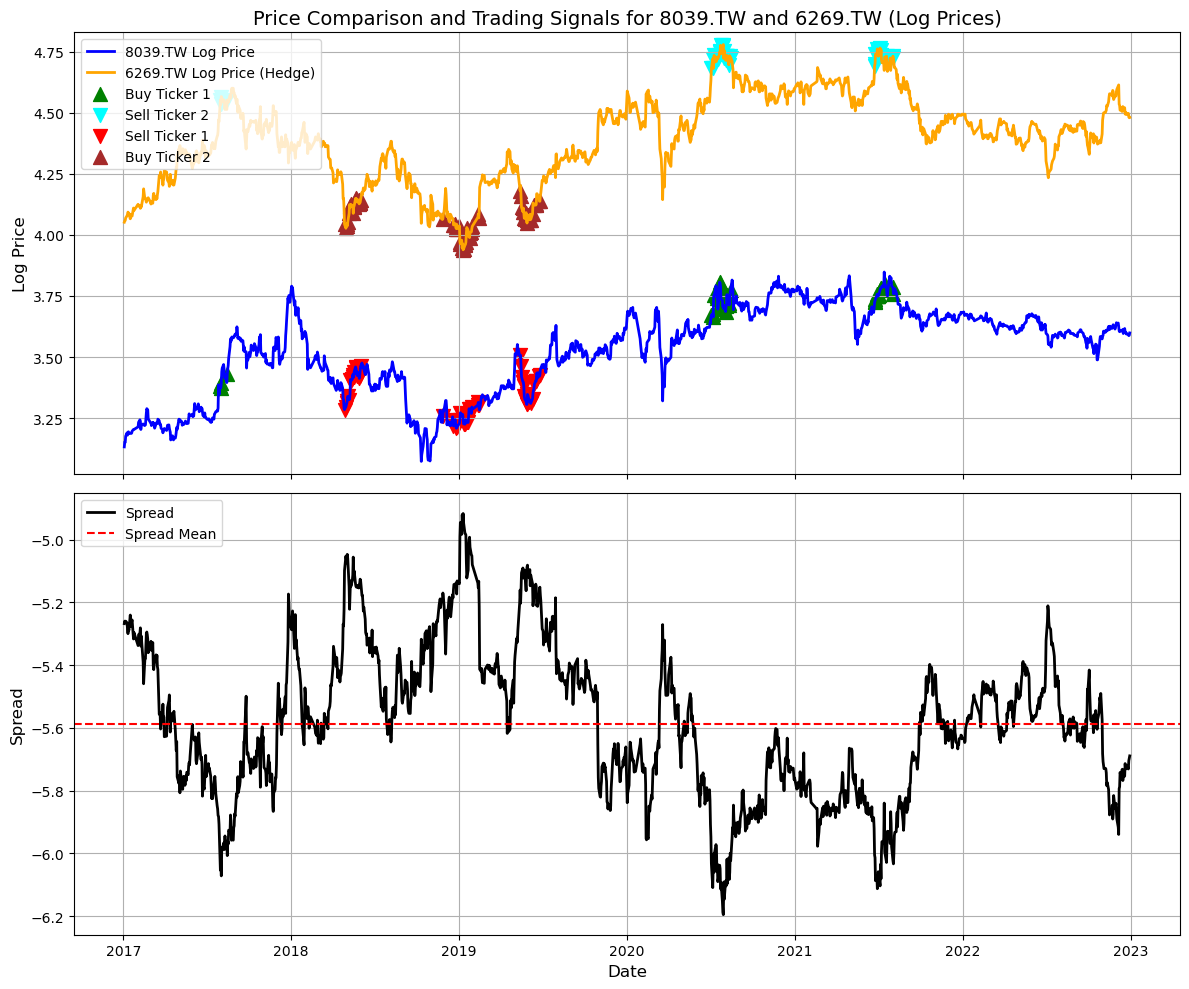

Results saved for 8039.TW and 6269.TW to 8039.TW_6269.TW_results.csv


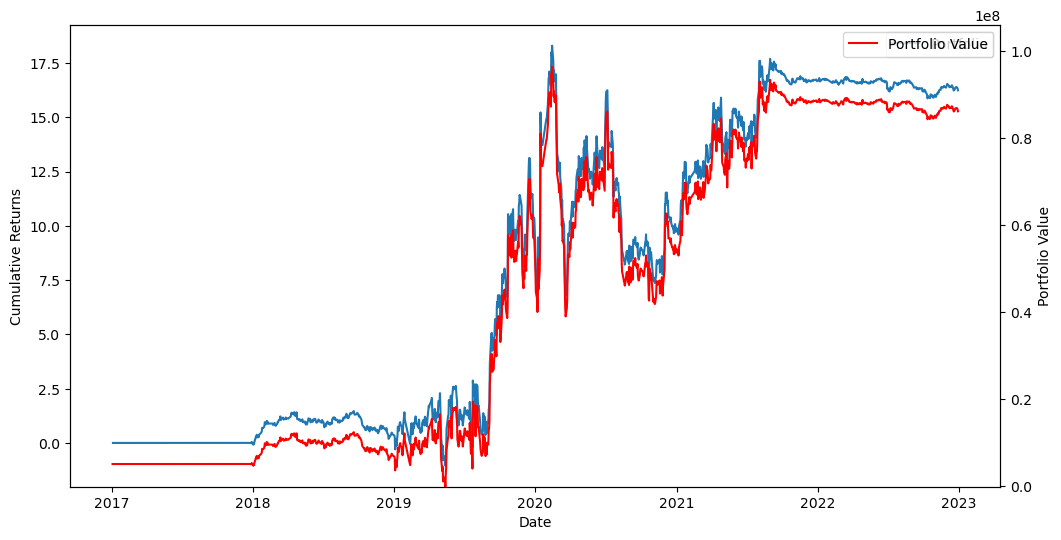

Sharpe Ratio: -0.105
CAGR: 60.83%
max drawdown: nan%


6239.TW    Spread Signal    8039.TW  6239.TW's trade  \
Date                                                                 
2017-01-03  56.974724  2.758065    NaN  22.923454              0.0   
2017-01-04  57.040504  2.750993    NaN  23.387897              0.0   
2017-01-05  56.579979  2.743468    NaN  23.354723              0.0   
2017-01-06  56.579979  2.733114    NaN  23.951859              0.0   
2017-01-09  57.237877  2.739034    NaN  24.283602              0.0   
...               ...       ...    ...        ...              ...   
2022-12-26  73.337814  2.821248    NaN  36.368538              0.0   
2022-12-27  73.068848  2.818074    NaN  36.324188              0.0   
2022-12-28  72.530922  2.812693    NaN  36.146774              0.0   
2022-12-29  71.992996  2.804746    NaN  36.191132              0.0   
2022-12-30  71.006775  2.786951    NaN  36.545944              0.0   

            8039.TW's trade  6239.TW's position  8039.TW's position  \
Date                                                                  
2017-01-03              0.0                 0.0                 0.0   
2017-01-04              0.0                 0.0                 0.0   
2017-01-05              0.0                 0.0                 0.0   
2017-01-06              0.0                 0.0                 0.0   
2017-01-09              0.0                 0.0                 0.0   
...                     ...                 ...                 ...   
2022-12-26              0.0            307530.0           -307530.0   
2022-12-27              0.0            307530.0           -307530.0   
2022-12-28              0.0            307530.0           -307530.0   
2022-12-29              0.0            307530.0           -307530.0   
2022-12-30              0.0            307530.0           -307530.0   

                    Cash  Position MTM  Portfolio Value   returns  cum returns  
Date                                                                            
2017-01-03  5.000000e+06  0.000000e+00     5.000000e+06       NaN          NaN  
2017-01-04  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-05  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-06  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-09  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
...                  ...           ...              ...       ...          ...  
2022-12-26  7.560149e+07  1.136916e+07     8.697065e+07  0.001588    16.394130  
2022-12-27  7.560149e+07  1.130009e+07     8.690157e+07 -0.000794    16.380315  
2022-12-28  7.560149e+07  1.118922e+07     8.679071e+07 -0.001276    16.358141  
2022-12-29  7.560149e+07  1.101015e+07     8.661164e+07 -0.002063    16.322327  
2022-12-30  7.560149e+07  1.059774e+07     8.619923e+07 -0.004762    16.239846  

[1465 rows x 13 columns]

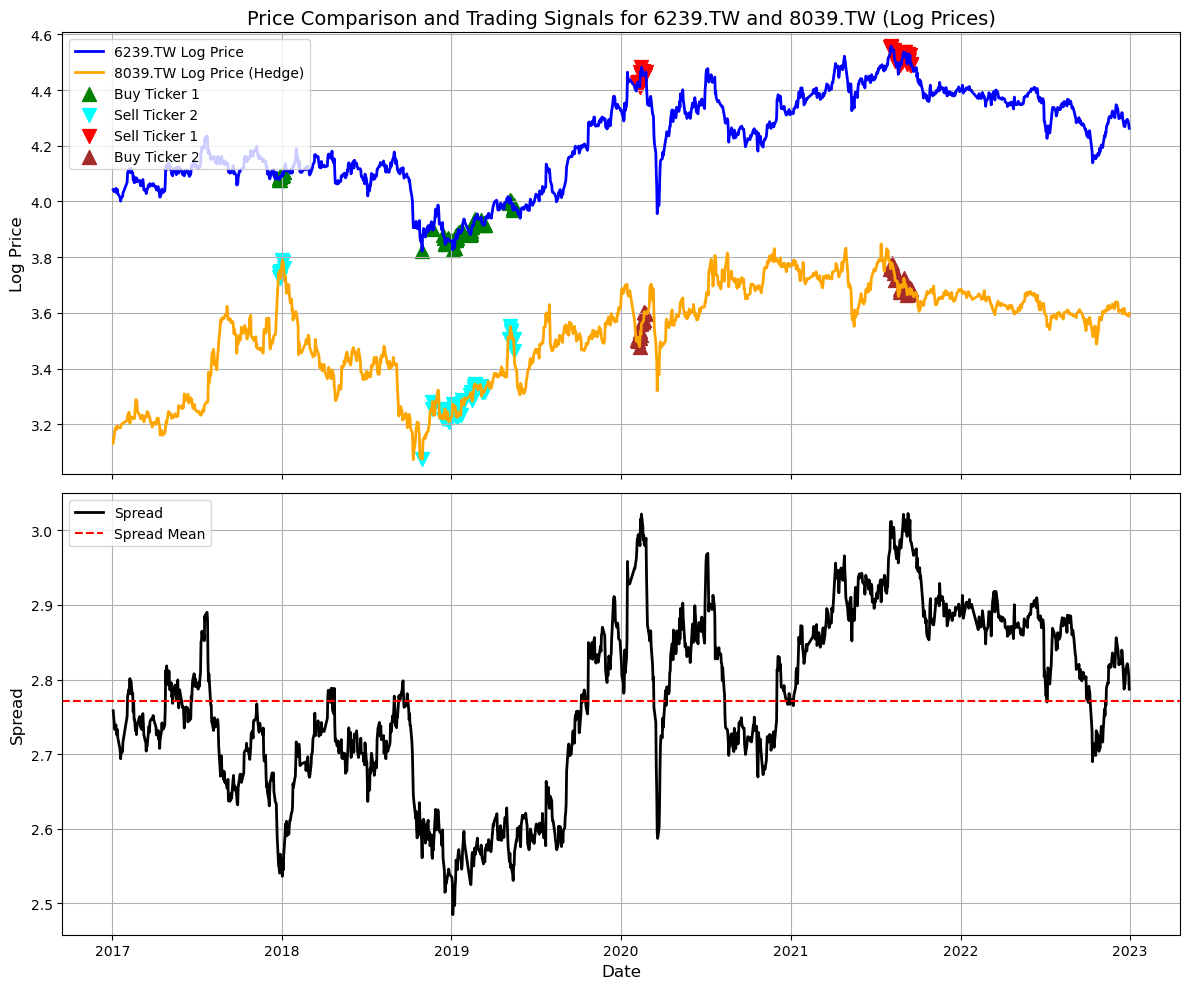

Results saved for 6239.TW and 8039.TW to 6239.TW_8039.TW_results.csv


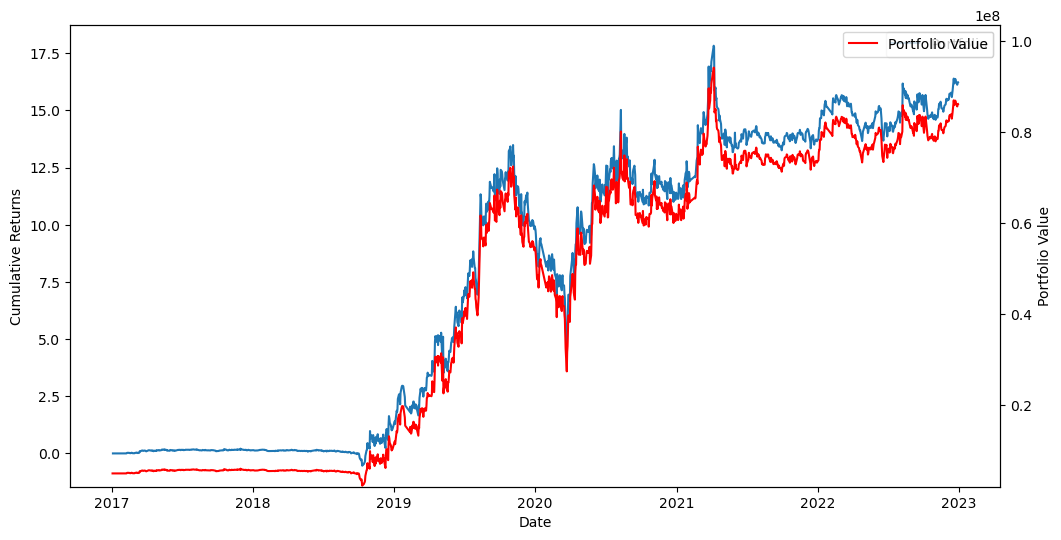

Sharpe Ratio: 1.001
CAGR: 60.81%
max drawdown: nan%


2312.TW     Spread Signal    2385.TW  2312.TW's trade  \
Date                                                                  
2017-01-03   9.861104 -14.445861    NaN  45.554295              0.0   
2017-01-04   9.861104 -14.434097    NaN  45.432163              0.0   
2017-01-05  10.026142 -14.429263    NaN  45.554295              0.0   
2017-01-06  10.067402 -14.377911    NaN  45.065777              0.0   
2017-01-09  10.067402 -14.360062    NaN  44.882584              0.0   
...               ...        ...    ...        ...              ...   
2022-12-26  13.248312 -16.455939    NaN  77.092010              0.0   
2022-12-27  13.248312 -16.450870    NaN  77.002884              0.0   
2022-12-28  13.103786 -16.436406    NaN  76.557266              0.0   
2022-12-29  12.959257 -16.462774    NaN  76.824638              0.0   
2022-12-30  13.007433 -16.464144    NaN  76.913757              0.0   

            2385.TW's trade  2312.TW's position  2385.TW's position  \
Date                                                                  
2017-01-03              0.0                 0.0                 0.0   
2017-01-04              0.0                 0.0                 0.0   
2017-01-05              0.0                 0.0                 0.0   
2017-01-06              0.0                 0.0                 0.0   
2017-01-09              0.0                 0.0                 0.0   
...                     ...                 ...                 ...   
2022-12-26              0.0          -1152158.0           1152158.0   
2022-12-27              0.0          -1152158.0           1152158.0   
2022-12-28              0.0          -1152158.0           1152158.0   
2022-12-29              0.0          -1152158.0           1152158.0   
2022-12-30              0.0          -1152158.0           1152158.0   

                    Cash  Position MTM  Portfolio Value   returns  cum returns  
Date                                                                            
2017-01-03  5.000000e+06  0.000000e+00     5.000000e+06       NaN          NaN  
2017-01-04  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-05  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-06  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
2017-01-09  5.000000e+06  0.000000e+00     5.000000e+06  0.000000     0.000000  
...                  ...           ...              ...       ...          ...  
2022-12-26  1.248648e+07  7.355803e+07     8.604450e+07 -0.009552    16.208901  
2022-12-27  1.248648e+07  7.345534e+07     8.594182e+07 -0.001193    16.188363  
2022-12-28  1.248648e+07  7.310844e+07     8.559491e+07 -0.004037    16.118982  
2022-12-29  1.248648e+07  7.358301e+07     8.606949e+07  0.005544    16.213897  
2022-12-30  1.248648e+07  7.363018e+07     8.611666e+07  0.000548    16.223332  

[1465 rows x 13 columns]

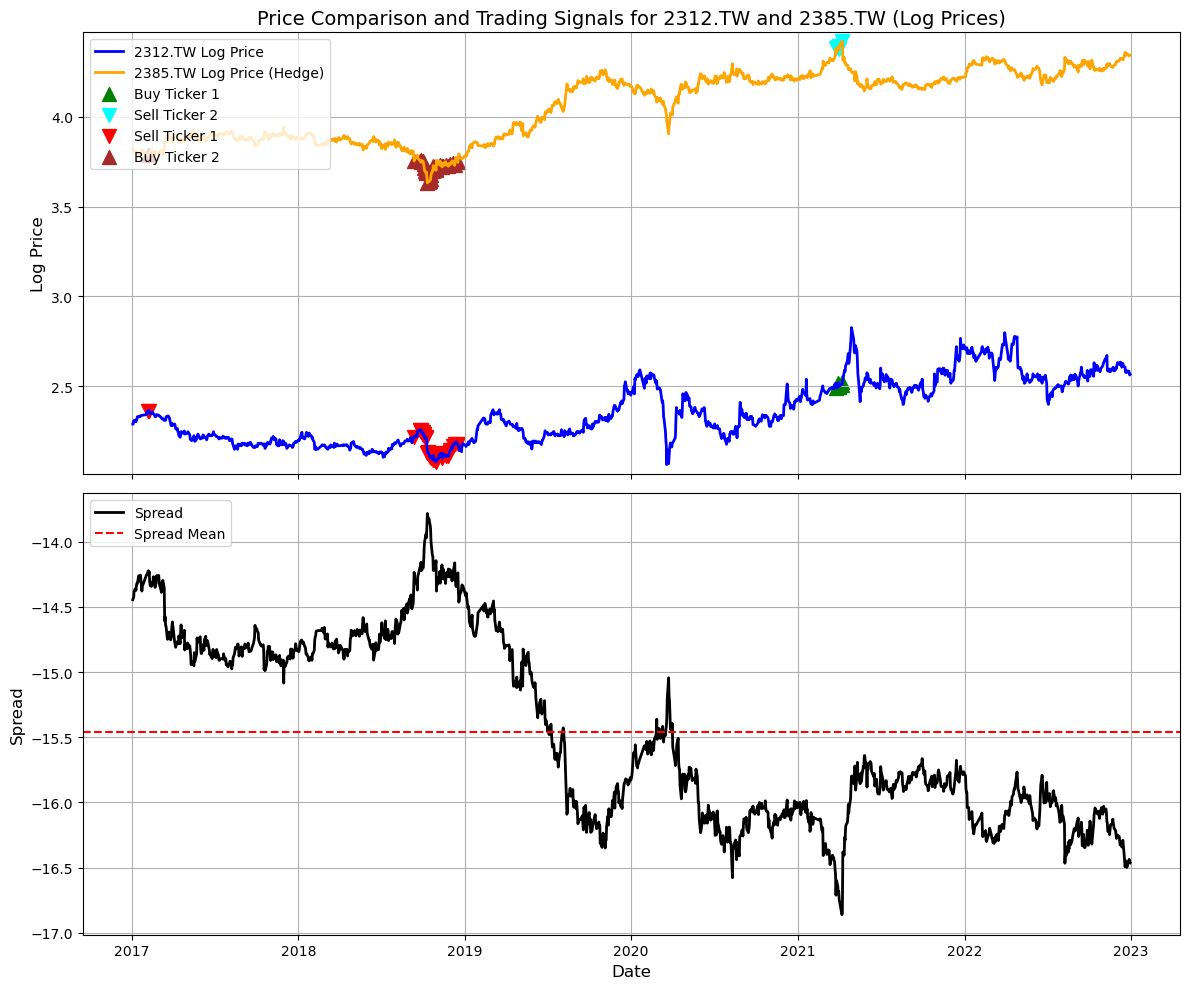

Results saved for 2312.TW and 2385.TW to 2312.TW_2385.TW_results.csv


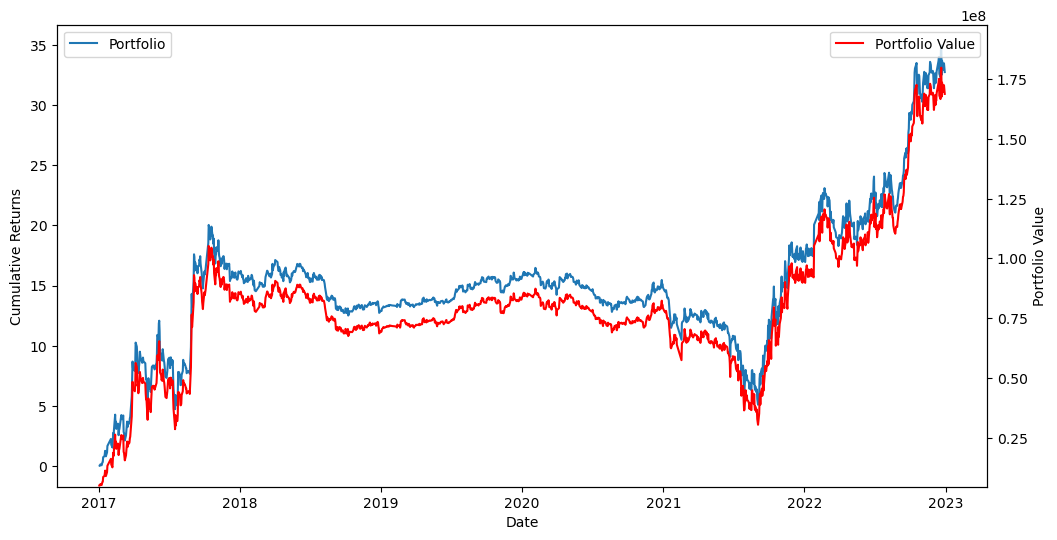

Sharpe Ratio: 1.187
CAGR: 79.92%
max drawdown: -74.63%


2337.TW    Spread Signal    2441.TW  2337.TW's trade  \
Date                                                                 
2017-01-03   6.662625 -2.009267    Buy  24.955187         375227.0   
2017-01-04   6.633657 -2.007349    Buy  24.826550         376866.0   
2017-01-05   6.879886 -1.980303    Buy  25.019506         363378.0   
2017-01-06   7.299920 -1.917917    Buy  24.955187         342470.0   
2017-01-09   7.415792 -1.920799    Buy  25.341093         337118.0   
...               ...       ...    ...        ...              ...   
2022-12-26  31.845284 -1.118082    NaN  43.448242              0.0   
2022-12-27  31.938398 -1.105055    NaN  43.088047              0.0   
2022-12-28  31.286592 -1.103914    NaN  42.322643              0.0   
2022-12-29  31.426266 -1.113585    NaN  42.817905              0.0   
2022-12-30  31.426266 -1.125020    NaN  43.223122              0.0   

            2441.TW's trade  2337.TW's position  2441.TW's position  \
Date                                                                  
2017-01-03        -375227.0            375227.0           -375227.0   
2017-01-04        -376866.0            752093.0           -752093.0   
2017-01-05        -363378.0           1115471.0          -1115471.0   
2017-01-06        -342470.0           1457941.0          -1457941.0   
2017-01-09        -337118.0           1795059.0          -1795059.0   
...                     ...                 ...                 ...   
2022-12-26              0.0           4795475.0          -4795475.0   
2022-12-27              0.0           4795475.0          -4795475.0   
2022-12-28              0.0           4795475.0          -4795475.0   
2022-12-29              0.0           4795475.0          -4795475.0   
2022-12-30              0.0           4795475.0          -4795475.0   

                    Cash  Position MTM  Portfolio Value   returns  cum returns  
Date                                                                            
2017-01-03  1.186386e+07 -6.863863e+06     5.000000e+06       NaN          NaN  
2017-01-04  1.872015e+07 -1.368275e+07     5.037399e+06  0.007480     0.007480  
2017-01-05  2.531168e+07 -2.023422e+07     5.077464e+06  0.007954     0.015493  
2017-01-06  3.135808e+07 -2.574034e+07     5.617747e+06  0.106408     0.123549  
2017-01-09  3.740103e+07 -3.217697e+07     5.224053e+06 -0.070080     0.044811  
...                  ...           ...              ...       ...          ...  
2022-12-26  2.253600e+08 -5.564170e+07     1.697183e+08 -0.021833    32.943667  
2022-12-27  2.253600e+08 -5.346786e+07     1.718922e+08  0.012808    33.378434  
2022-12-28  2.253600e+08 -5.292311e+07     1.724369e+08  0.003169    33.487385  
2022-12-29  2.253600e+08 -5.462832e+07     1.707317e+08 -0.009889    33.146342  
2022-12-30  2.253600e+08 -5.657153e+07     1.687885e+08 -0.011382    32.757701  

[1465 rows x 13 columns]

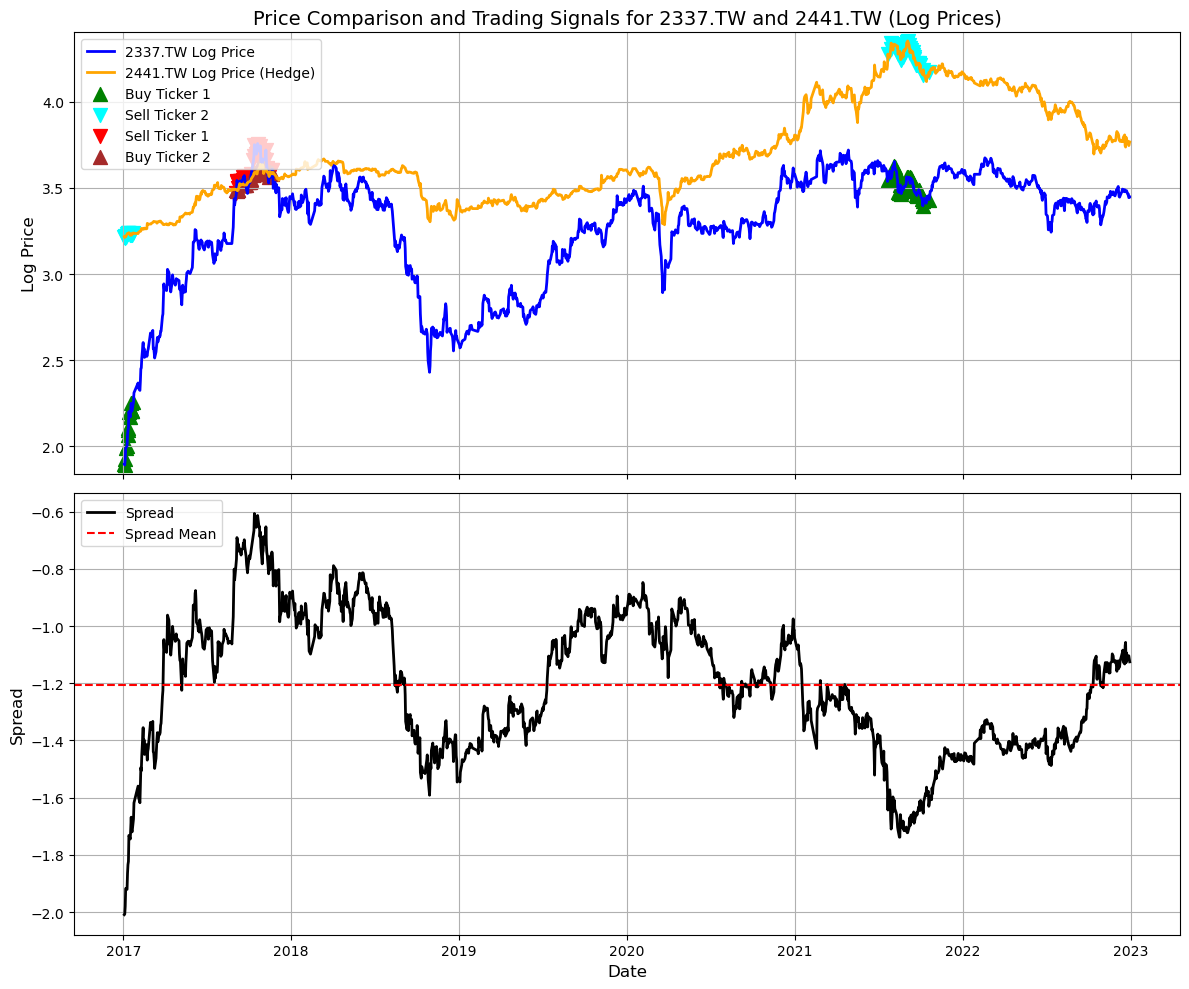

Results saved for 2337.TW and 2441.TW to 2337.TW_2441.TW_results.csv


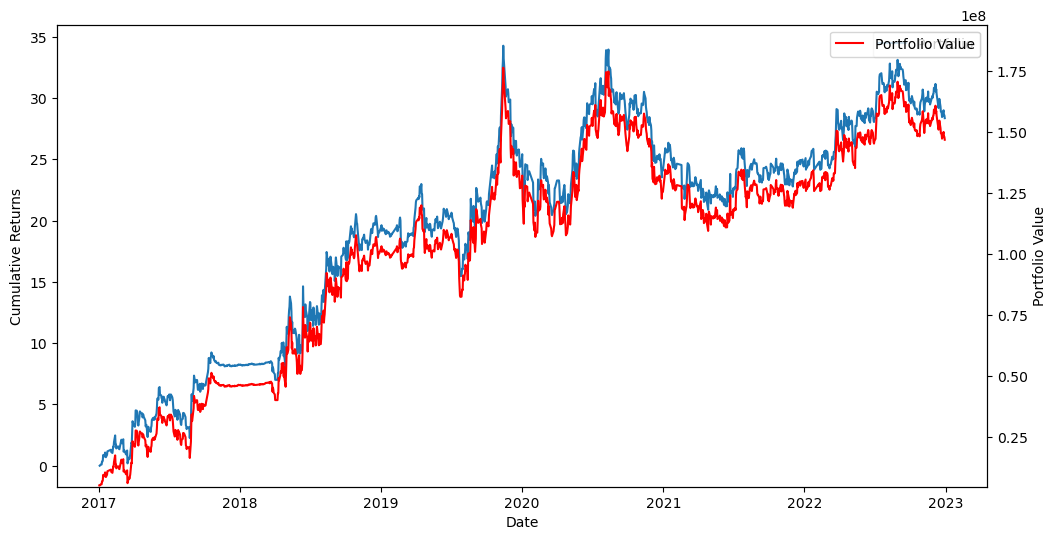

Sharpe Ratio: 1.131
CAGR: 75.78%
max drawdown: -92.33%


2337.TW    Spread Signal    2313.TW  2337.TW's trade  \
Date                                                                 
2017-01-03   6.662625 -0.331031    Buy  11.872496         375227.0   
2017-01-04   6.633657 -0.338270    Buy  11.910547         376866.0   
2017-01-05   6.879886 -0.307558    Buy  11.986653         363378.0   
2017-01-06   7.299920 -0.262475    Buy  12.176917         342470.0   
2017-01-09   7.415792 -0.249536    Buy  12.214972         337118.0   
...               ...       ...    ...        ...              ...   
2022-12-26  31.845284  0.084682    NaN  42.524918              0.0   
2022-12-27  31.938398  0.081762    NaN  42.801659              0.0   
2022-12-28  31.286592  0.092735    NaN  41.325737              0.0   
2022-12-29  31.426266  0.093179    NaN  41.510227              0.0   
2022-12-30  31.426266  0.103239    NaN  41.049000              0.0   

            2313.TW's trade  2337.TW's position  2313.TW's position  \
Date                                                                  
2017-01-03        -375227.0            375227.0           -375227.0   
2017-01-04        -376866.0            752093.0           -752093.0   
2017-01-05        -363378.0           1115471.0          -1115471.0   
2017-01-06        -342470.0           1457941.0          -1457941.0   
2017-01-09        -337118.0           1795059.0          -1795059.0   
...                     ...                 ...                 ...   
2022-12-26              0.0          -2589630.0           2589630.0   
2022-12-27              0.0          -2589630.0           2589630.0   
2022-12-28              0.0          -2589630.0           2589630.0   
2022-12-29              0.0          -2589630.0           2589630.0   
2022-12-30              0.0          -2589630.0           2589630.0   

                    Cash  Position MTM  Portfolio Value   returns  cum returns  
Date                                                                            
2017-01-03  6.954884e+06 -1.954884e+06     5.000000e+06       NaN          NaN  
2017-01-04  8.943565e+06 -3.968712e+06     4.974853e+06 -0.005029    -0.005029  
2017-01-05  1.079925e+07 -5.696451e+06     5.102800e+06  0.025719     0.020560  
2017-01-06  1.246948e+07 -7.110374e+06     5.359103e+06  0.050228     0.071821  
2017-01-09  1.408737e+07 -8.614810e+06     5.472557e+06  0.021170     0.094511  
...                  ...           ...              ...       ...          ...  
2022-12-26  1.218856e+08  2.765630e+07     1.495419e+08  0.015533    28.908383  
2022-12-27  1.218856e+08  2.813182e+07     1.500174e+08  0.003180    29.003488  
2022-12-28  1.218856e+08  2.599767e+07     1.478833e+08 -0.014226    28.576657  
2022-12-29  1.218856e+08  2.611373e+07     1.479993e+08  0.000785    28.599869  
2022-12-30  1.218856e+08  2.491932e+07     1.468049e+08 -0.008070    28.360987  

[1465 rows x 13 columns]

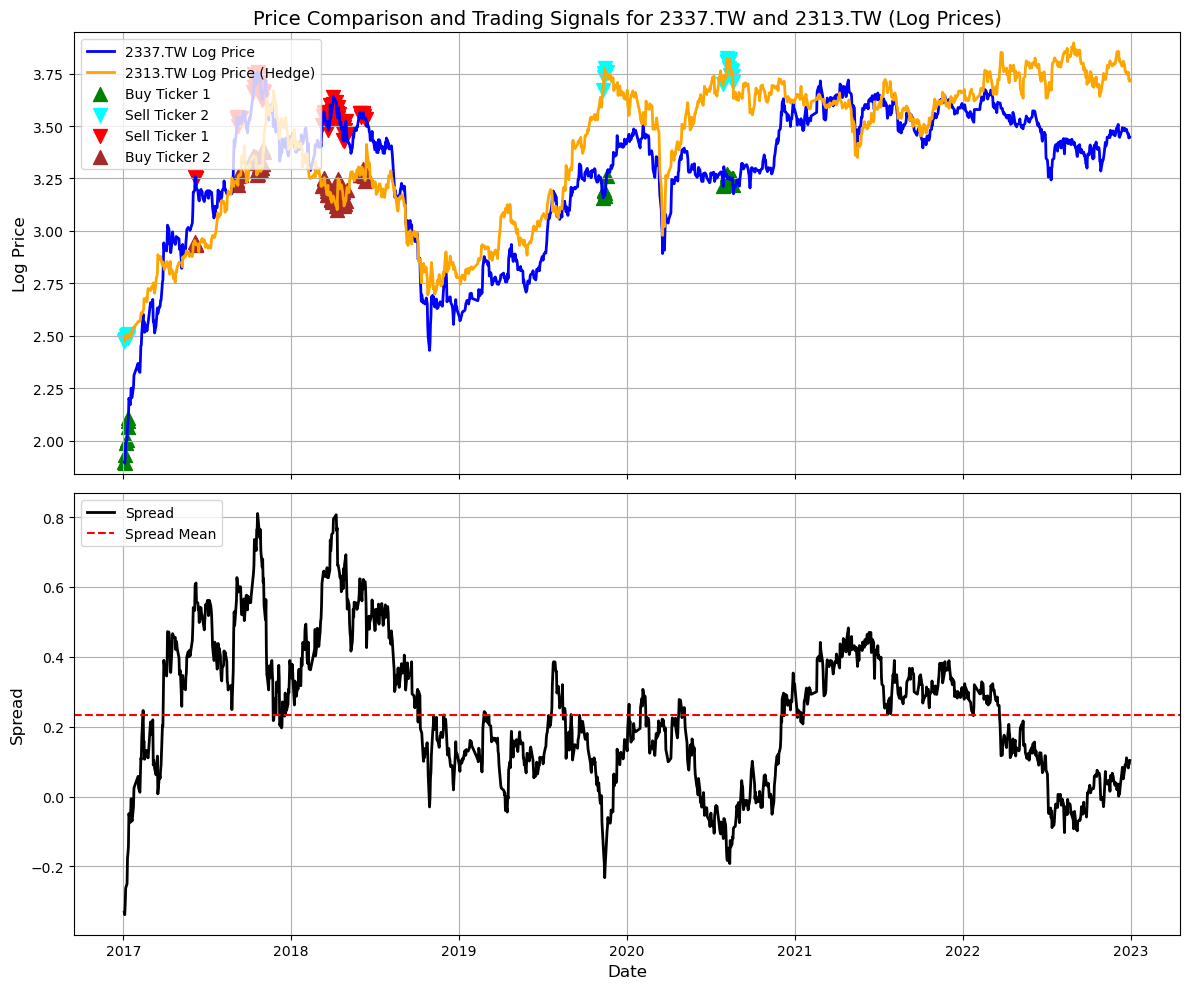

Results saved for 2337.TW and 2313.TW to 2337.TW_2313.TW_results.csv


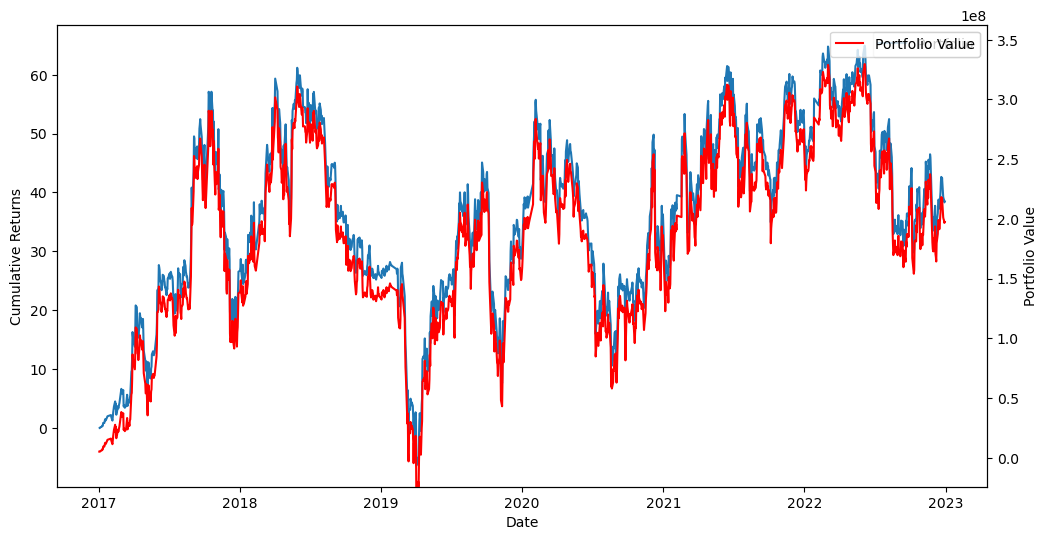

Sharpe Ratio: -0.306
CAGR: 84.67%
max drawdown: -110.49%


2337.TW    Spread Signal    2392.TW  2337.TW's trade  \
Date                                                                 
2017-01-03   6.662625  0.215672    Buy  25.158487         375227.0   
2017-01-04   6.633657  0.209903    Buy  25.226767         376866.0   
2017-01-05   6.879886  0.244237    Buy  25.329172         363378.0   
2017-01-06   7.299920  0.306316    Buy  25.192631         342470.0   
2017-01-09   7.415792  0.322771    Buy  25.158487         337118.0   
...               ...       ...    ...        ...              ...   
2022-12-26  31.845284  1.617414    NaN  34.372543              0.0   
2022-12-27  31.938398  1.617532    NaN  34.557842              0.0   
2022-12-28  31.286592  1.606074    NaN  33.955631              0.0   
2022-12-29  31.426266  1.606280    NaN  34.233574              0.0   
2022-12-30  31.426266  1.606986    NaN  34.187252              0.0   

            2392.TW's trade  2337.TW's position  2392.TW's position  \
Date                                                                  
2017-01-03        -375227.0            375227.0           -375227.0   
2017-01-04        -376866.0            752093.0           -752093.0   
2017-01-05        -363378.0           1115471.0          -1115471.0   
2017-01-06        -342470.0           1457941.0          -1457941.0   
2017-01-09        -337118.0           1795059.0          -1795059.0   
...                     ...                 ...                 ...   
2022-12-26              0.0          16600736.0         -16600736.0   
2022-12-27              0.0          16600736.0         -16600736.0   
2022-12-28              0.0          16600736.0         -16600736.0   
2022-12-29              0.0          16600736.0         -16600736.0   
2022-12-30              0.0          16600736.0         -16600736.0   

                    Cash  Position MTM  Portfolio Value   returns  cum returns  
Date                                                                            
2017-01-03  1.194015e+07 -6.940147e+06     5.000000e+06       NaN          NaN  
2017-01-04  1.894726e+07 -1.398375e+07     4.963510e+06 -0.007298    -0.007298  
2017-01-05  2.565132e+07 -2.057964e+07     5.071678e+06  0.021793     0.014336  
2017-01-06  3.177904e+07 -2.608652e+07     5.692523e+06  0.122414     0.138505  
2017-01-09  3.776042e+07 -3.184918e+07     5.911237e+06  0.038421     0.182247  
...                  ...           ...              ...       ...          ...  
2022-12-26  2.431537e+08 -4.195437e+07     2.011993e+08 -0.074565    39.239860  
2022-12-27  2.431537e+08 -4.348470e+07     1.996690e+08 -0.007606    38.933795  
2022-12-28  2.431537e+08 -4.430801e+07     1.988457e+08 -0.004123    38.769133  
2022-12-29  2.431537e+08 -4.660338e+07     1.965503e+08 -0.011543    38.310058  
2022-12-30  2.431537e+08 -4.583441e+07     1.973193e+08  0.003912    38.463853  

[1465 rows x 13 columns]

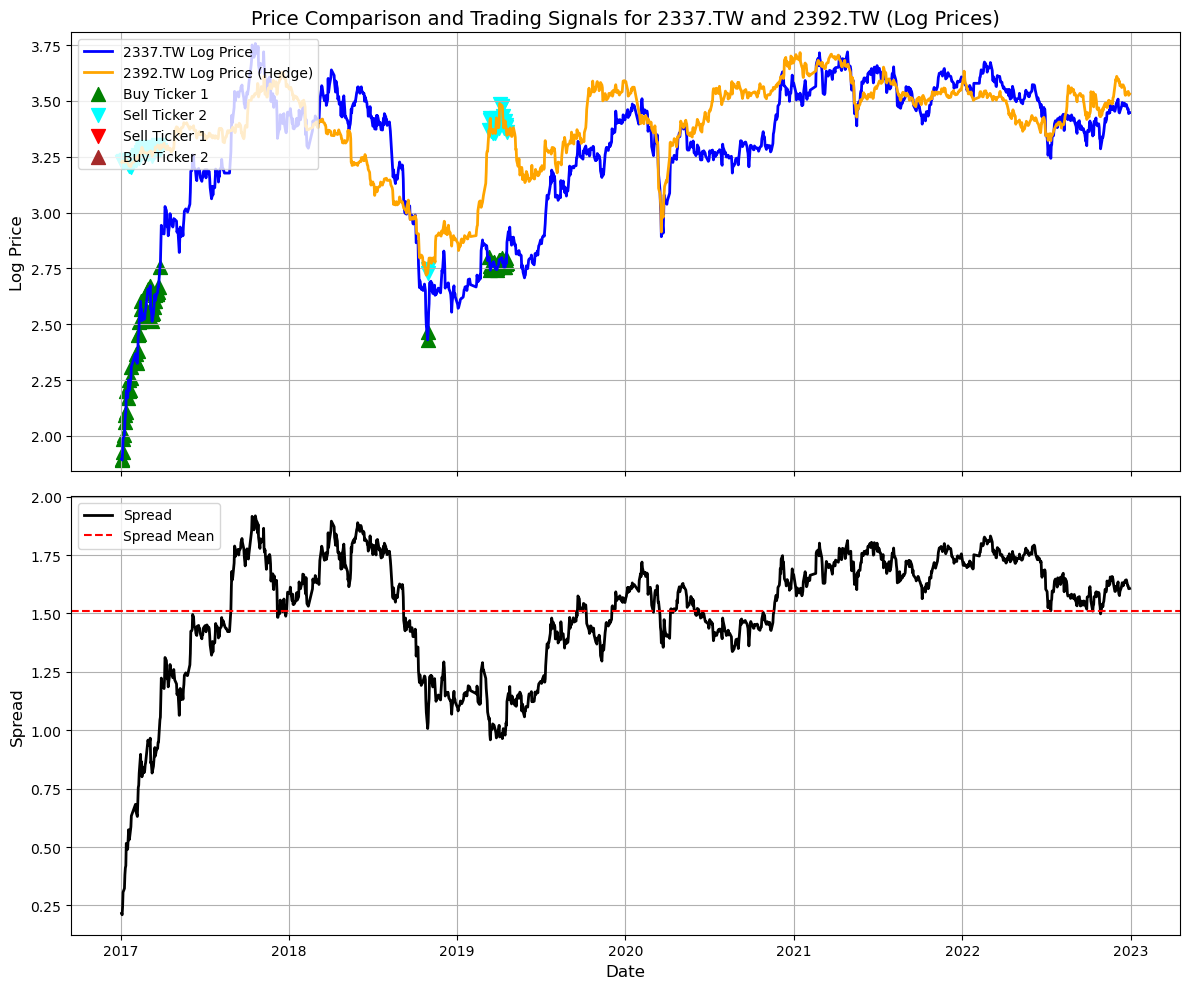

Results saved for 2337.TW and 2392.TW to 2337.TW_2392.TW_results.csv


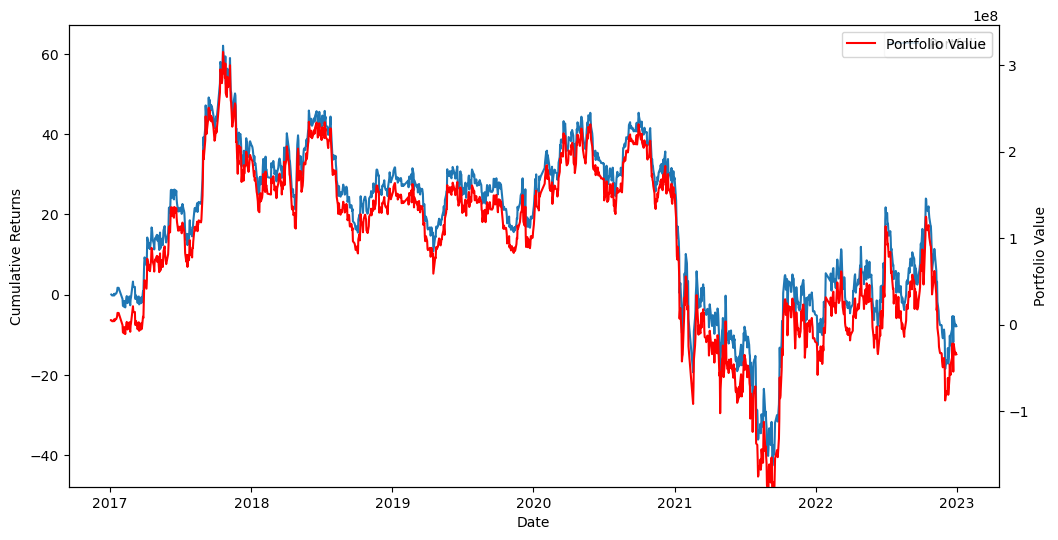

Sharpe Ratio: -0.389
CAGR: nan%
max drawdown: -290.57%


2337.TW    Spread Signal    3711.TW  2337.TW's trade  \
Date                                                                 
2017-01-03   6.662625 -3.723099    Buy  45.965420         375227.0   
2017-01-04   6.633657 -3.727457    Buy  45.965420         376866.0   
2017-01-05   6.879886 -3.711015    Buy  46.596039         363378.0   
2017-01-06   7.299920 -3.688812    Buy  47.787220         342470.0   
2017-01-09   7.415792 -3.677362    Buy  47.927357         337118.0   
...               ...       ...    ...        ...              ...   
2022-12-26  31.845284 -3.053597    NaN  84.558746              0.0   
2022-12-27  31.938398 -3.058465    NaN  85.008522              0.0   
2022-12-28  31.286592 -3.063467    NaN  84.108963              0.0   
2022-12-29  31.426266 -3.063715    NaN  84.378838              0.0   
2022-12-30  31.426266 -3.065279    NaN  84.468788              0.0   

            3711.TW's trade  2337.TW's position  3711.TW's position  \
Date                                                                  
2017-01-03        -375227.0            375227.0           -375227.0   
2017-01-04        -376866.0            752093.0           -752093.0   
2017-01-05        -363378.0           1115471.0          -1115471.0   
2017-01-06        -342470.0           1457941.0          -1457941.0   
2017-01-09        -337118.0           1795059.0          -1795059.0   
...                     ...                 ...                 ...   
2022-12-26              0.0           9651532.0          -9651532.0   
2022-12-27              0.0           9651532.0          -9651532.0   
2022-12-28              0.0           9651532.0          -9651532.0   
2022-12-29              0.0           9651532.0          -9651532.0   
2022-12-30              0.0           9651532.0          -9651532.0   

                    Cash  Position MTM  Portfolio Value   returns  cum returns  
Date                                                                            
2017-01-03  1.974747e+07 -1.474747e+07     5.000000e+06       NaN          NaN  
2017-01-04  3.457027e+07 -2.958114e+07     4.989131e+06 -0.002174    -0.002174  
2017-01-05  4.900225e+07 -4.430222e+07     4.700033e+06 -0.057945    -0.059993  
2017-01-06  6.286794e+07 -5.902809e+07     3.839841e+06 -0.183018    -0.232032  
2017-01-09  7.652511e+07 -7.272065e+07     3.804465e+06 -0.009213    -0.239107  
...                  ...           ...              ...       ...          ...  
2022-12-26  4.775362e+08 -5.087657e+08    -3.122945e+07  0.400207    -7.245889  
2022-12-27  4.775362e+08 -5.122080e+08    -3.467177e+07  0.110227    -7.934354  
2022-12-28  4.775362e+08 -5.098168e+08    -3.228057e+07 -0.068967    -7.456115  
2022-12-29  4.775362e+08 -5.110734e+08    -3.353722e+07  0.038929    -7.707443  
2022-12-30  4.775362e+08 -5.119416e+08    -3.440538e+07  0.025886    -7.881075  

[1465 rows x 13 columns]

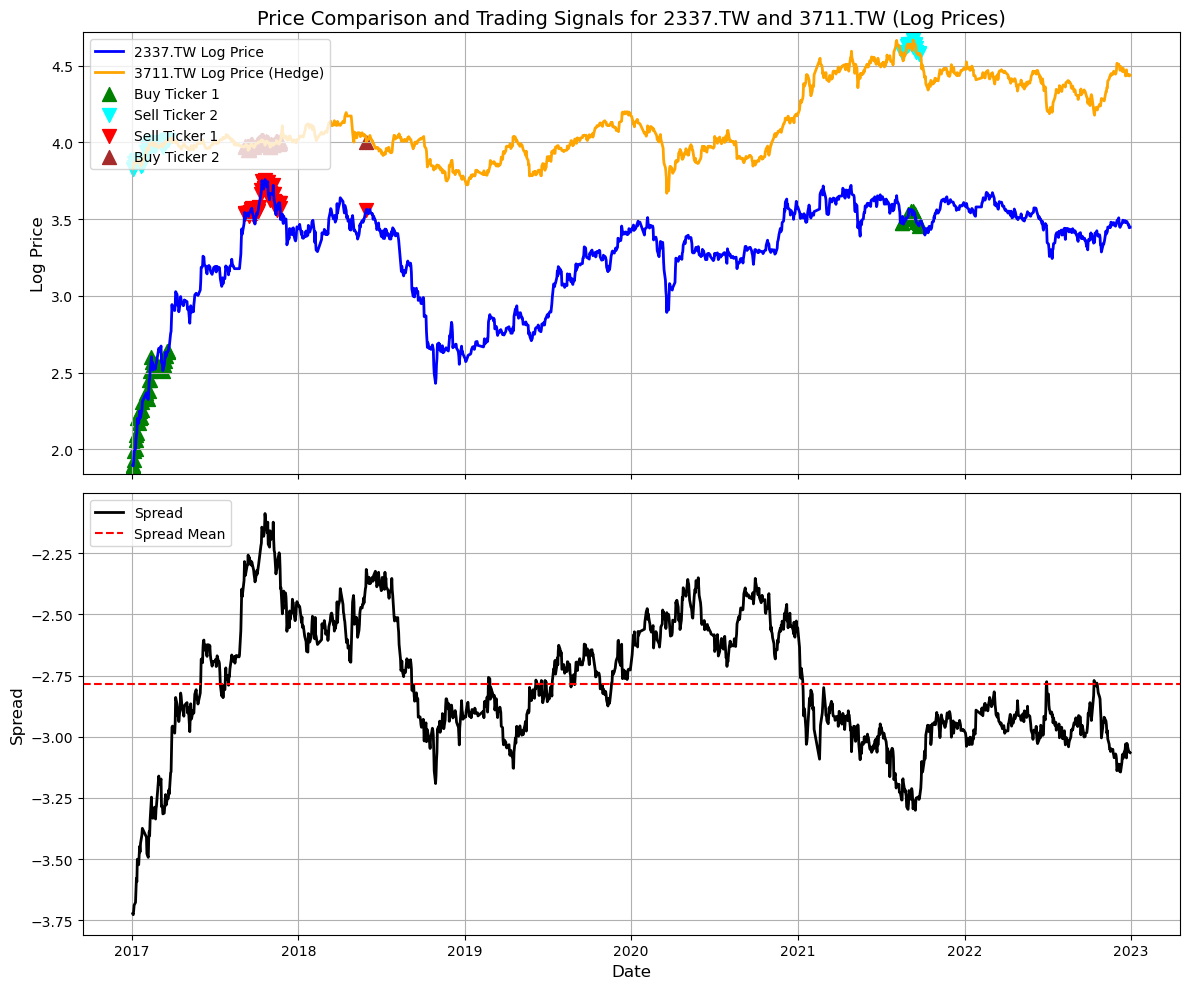

Results saved for 2337.TW and 3711.TW to 2337.TW_3711.TW_results.csv


In [354]:
for index, row in FPairs.iterrows():
    ticker1 = row[0]  # Assuming FPairs has tickers in the first and second columns
    ticker2 = row[1]

    # Running the backtest process for each pair
    price_df = Backtest.position(ticker1, ticker2)
    portfolio = Backtest.cashflow(price_df)  # Calculate cashflow
    performance = Backtest.metric(price_df)  # Calculate performance metrics
    display(performance)
    Backtest.signal_plot(price_df, HR)

    # Save the results to CSV dynamically based on ticker names
    filename = f"{ticker1}_{ticker2}_results.csv"
    
    # Saving the portfolio DataFrame to CSV
    portfolio.to_csv(filename)
    print(f"Results saved for {ticker1} and {ticker2} to {filename}")
